<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Marcelo Rojas B.
- Nombre de alumno 2: Sebastián Sanhueza O.


## Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer material del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

### **Link de repositorio de GitHub:** `https://github.com/Marcelorojasb/MDS7202`

# Importamos librerias útiles

In [ ]:
!pip install -qq xgboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
import itertools
import joblib
import matplotlib.pyplot as plt
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor

# 1. El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterización de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1.1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas.
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?
7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

Se lleva a cabo un breve análisis de las correlaciones entre las variables del conjunto de datos con el fin de identificar aquellas que puedan contener información redundante o poco relevante para predecir la variable `quantity`. Se utilizó la función `v_cramer` para calcular el coeficiente de V de Cramer entre las variables. A continuación se presentan los resultados obtenidos:

In [ ]:
# Se copia el método utilizado en el proyecto 1 para poder observar variables que tengan
# información redundante dentro del dataframe
def v_cramer(variables):
  corrM = np.zeros((len(variables), len(variables)))
  for var1, var2 in itertools.combinations_with_replacement(variables, 2):
    i, j = variables.index(var1), variables.index(var2)
    # Calcula la matriz de confusión entre dos variables del dataset
    confusion_matrix = pd.crosstab(df[var1], df[var2])
    # Calcula el coeficiente chi-cuadrado entre las variables
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    minimum_dimension = min(confusion_matrix.shape) - 1
    # Calcula el coeficiente V de Cramer entre las variables
    corr_value = np.sqrt((chi2 / n) / minimum_dimension)
    # Se registra el resultado de tal forma que sea una metriz simétrica
    corrM[i, j] = corr_value
    corrM[j, i] = corr_value

  cramerM = pd.DataFrame(corrM, index=variables, columns=variables)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cramerM, annot=True, fmt=".2f")
  plt.title('Coeficiente V Cramer entre variables.')
  plt.show()

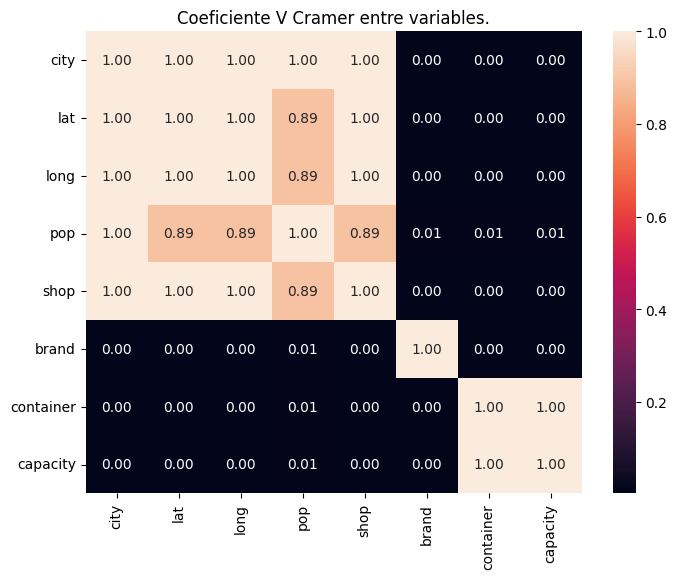

In [ ]:
# Visualizamos las correlaciones entre las variables
variables_1 = ['city', 'lat', 'long', 'pop', 'shop', 'brand', 'container', 'capacity']
v_cramer(variables=variables_1)


Tras el análisis previo, se opta por descartar la variable `id` por carecer de relevancia para la resolución del problema. Asimismo, se decide suprimir `lat` y `long`, que representan la latitud y longitud de los locales (`shop`) respectivamente, al considerarse información redundante en el conjunto de datos.

Además, se identifica una relación directa entre `container` y `capacity`: los contenedores `glass` están asociados a 500 ml, `plastic` a 1.5 litros y `can` a 330 ml. En consecuencia, se elige eliminar `capacity`, ya que solo aporta información redundante.

Por consiguiente, se procede a reducir el dataset original eliminando las variables mencionadas.

In [ ]:
# Dropeamos las columnas de id, latitude, longitude and capacity
df_reduced = df.drop(columns=['id', 'lat', 'long', 'capacity'])
df_reduced.head()

,date,city,pop,shop,brand,container,price,quantity
0,2012-01-31,Athens,672130,shop_1,kinder-cola,glass,0.96,13280
1,2012-01-31,Athens,672130,shop_1,kinder-cola,plastic,2.86,6727
2,2012-01-31,Athens,672130,shop_1,kinder-cola,can,0.87,9848
3,2012-01-31,Athens,672130,shop_1,adult-cola,glass,1.00,20050
4,2012-01-31,Athens,672130,shop_1,adult-cola,can,0.39,25696


Después, creamos conjuntos de entrenamiento, validación y prueba distribuyendo los datos en un 70%, 20% y 10%, respectivamente, de la data original.

In [ ]:
# Generamos los conjuntos de train, validation y test

features = df_reduced.drop(columns=['quantity'])
labels = df_reduced.loc[:, 'quantity']

# Porcentajes de la data asignados a cada conjunto
train_ratio = 0.70
val_ratio = 0.20
test_ratio = 0.10

# Genera el conjunto de test
X_remaining, X_test, y_remaining, y_test = train_test_split(features, labels, test_size=test_ratio, shuffle=False, random_state=42)

# Genera los conjuntos de train y valdiation
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, test_size=val_ratio/(1 - test_ratio), random_state=42)

print(f'Dimensiones y porcentajes: \nTrain:{X_train.shape}, {round((100*(X_train.shape[0]/features.shape[0])),1)}%\
      \nValidation:{X_val.shape}, {round((100*(X_val.shape[0]/features.shape[0])),1)}%\
      \nTest:{X_test.shape}, {round((100*(X_test.shape[0]/features.shape[0])),1)}%')

Dimensiones y porcentajes: 
Train:(5218, 7), 70.0%      
Validation:(1492, 7), 20.0%      
Test:(746, 7), 10.0%


Se inicia creando una función denominada `date_transformer`. Su propósito es detectar las variables de tipo `datetime` en un DataFrame para luego añadir nuevas columnas que contengan información sobre el día, mes y año extraídos de cada variable de tipo `datetime`. Luego esta función será ingresada en un `FunctionTransformer` para tratar con la variable `date` del dataset utilizado.

Por otra parte, debido a que las variables de tipo numérico que están presentes en el dataset de entrenamiento son `pop` y `price` que representan la población de la ciudad correspondiente y el precio de la soda, por lo que se decidió aplicar dos transformaciones, primero una transformación logarítimica y segundo una escalamiento de tipo Min-Max.

Luego se procedió a implementar un `ColumnTransformer` en donde se procesarán las variables numéricas con los métodos anteriores y las variables categóricas que se les aplicará una transformación de tipo `OneHotEncoder`.

Finalmente, se aplicaron el `FunctionTransformer` y el `ColumnTranformer` en un Pipeline junto con un regresor del tipo `DummyRegressor`, el cual es un modelo básico utilizado como referencia para determinar si un modelo más sofisticado está aprendiendo patrones reales en los datos o simplemente está replicando resultados predecibles sin un aprendizaje significativo.



In [ ]:
# Diseñamos el FunctionTransformer para la variable 'date'

# Función para transformar las variables de tipo datetime
def date_transformer(df):
  """Transforma las columnas de tipo datetime en un DataFrame de pandas
     en columnas categóricas con el año, mes y día.

  Parameters:
  ----------------------
  df: pandas.DataFrame
    DataFrame de pandas que se ingresa para procesar.

  Returns:
  ----------------------
  df: pandas.DataFrame
    DataFrame de pandas con las variables de tipo datetime transformadas

  """
  df = df.copy() # Copia de los datos de entrada
  # Extracción de las columnas de tipo datetime
  datetime_columns = df.select_dtypes(include='datetime').columns
  # Extracción del año, mes y dia de las columnas de tipo datetime y su conversión
  # a nuevas columnas del DataFrame de tipo categorical
  for column in datetime_columns:
    df[column + '_year'] = df[column].apply(lambda x: x.year).astype('category') # Año
    df[column + '_month'] = df[column].apply(lambda x: x.month).astype('category') # Mes
    df[column + '_day'] = df[column].apply(lambda x: x.day).astype('category') # Dia
    df = df.drop(column, axis=1)
  return df

# Implementación del FunctionTransformer
datetime_transformer = FunctionTransformer(func=date_transformer, validate=False)

# Implementación del ColumnTransformer
numeric_transformers = Pipeline(steps=[
          ('log_transform', FunctionTransformer(func=np.log1p, validate=False)),
           ('min_max_scaling', MinMaxScaler())
           ])

column_transformer = ColumnTransformer(
    transformers=[
        (
            'num',
            numeric_transformers,
            make_column_selector(dtype_include=['int64', 'float64'])
        ),
        (
            'cat',
            OneHotEncoder(
                sparse_output=False,
                handle_unknown="ignore"
                ),
             make_column_selector(dtype_include=['object', 'category'])
        )
                 ],
    remainder='passthrough', verbose_feature_names_out=False
    )


In [ ]:
# Implementación del Pipeline con DummyRegressor
dummy_pipe = Pipeline(steps=[
    ('date_transform', datetime_transformer),
    ('column_transform', column_transformer),
    ('dummy_regressor', DummyRegressor(strategy='mean'))])
# Visualización del Pipeline
dummy_pipe

Pipeline(steps=[('date_transform',
                 FunctionTransformer(func=<function date_transformer at 0x7c75d0a4d120>)),
                ('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('min_max_scaling',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c75d0a3fee0>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c75d0a3f700>)],
                                   verbose_feature_names_out=False)),
                ('dummy_regressor', DummyRegressor())])

Se entrena el modelo básico utilizando como métrica de evaluación de desempeño el `Mean Absolute Error (MAE)`, la cual es una métrica que calcula la magnitud promedio de los errores entre las predicciones y los valores reales. Este cálculo se realiza tomando la diferencia absoluta entre cada predicción y su valor real, sumándolas y luego dividiéndolas por el número total de muestras. De esta forma un MAE más bajo indica una menor magnitud de error y, por lo tanto, un mejor ajuste del modelo a los datos.

In [ ]:
# Entrenamiento del Pipeline con los datos de train
dummy_pipe.fit(X_train, y_train)

# Obtención de las predicciones en el conjunto de validación
dummy_predictions = dummy_pipe.predict(X_val)

# Calculo del mean_absolute_error sobre los datos de validación
mae = mean_absolute_error(y_val, dummy_predictions)
print(f"Mean Absolute Error en datos de validación (DummyRegressor): {mae}")

Mean Absolute Error en datos de validación (DummyRegressor): 13350.331153914527


A partir del procedimiento anterior se obtuvo un MAE de 13350.33 aproximadamente para el modelo Dummy, lo cual, para efectos de este problema, se puede interpretar como una medida de cuanto difieren, en promedio, las predicciones del modelo de la cantidad real de ventas o demanda. En este caso, si el MAE es 13350 unidades, esto significa que, en promedio, las predicciones del modelo tienden a desviarse en ±13350 unidades de la cantidad real de ventas o demanda de bebidas.

Por lo tanto, si el MAE es bajo, el modelo tiende a predecir las cantidades de bebidas vendidas de manera muy cercana a las cantidades reales, lo que indica una buena capacidad de predicción. Sin embargo, si el MAE es alto, indica que las predicciones tienden a alejarse más de la cantidad real, lo que señala una menor precisión en la capacidad del modelo para predecir las ventas o demanda de bebidas

A continuación se implementó un nuevo Pipeline con las mismas transformaciones de variables que en el caso anterior, pero ahora aplicando una regresor del tipo `XGBRegressor`, el cual es un modelo de regresión basado en árboles de decisión, altamente eficiente y potente. Utiliza un algoritmo de boosting que combina múltiples árboles de decisión débiles para crear un modelo más fuerte y preciso. Este algoritmo busca minimizar una función de pérdida mediante la construcción iterativa de árboles, donde cada árbol se ajusta a los errores residuales del modelo anterior.

In [ ]:
# Implementación del Pipeline con XGBRegressor
boosting_pipe = Pipeline(steps=[
    ('date_transform', datetime_transformer),
    ('column_transform', column_transformer),
    ('xgb_regressor', XGBRegressor())])
# Visualización del Pipeline
boosting_pipe

Pipeline(steps=[('date_transform',
                 FunctionTransformer(func=<function date_transformer at 0x7c75d0a4d120>)),
                ('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('min_max_scaling',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_se...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Entrenamiento del Pipeline con los datos de train
boosting_pipe.fit(X_train, y_train)

# Obtención de las predicciones en el conjunto de validación
boosting_predictions = boosting_pipe.predict(X_val)

# Calculo el mean_absolute_error sobre los datos de validación
mae = mean_absolute_error(y_val, boosting_predictions)
print(f"Mean Absolute Error en datos de validación (XGBRegressor): {mae}")

Mean Absolute Error en datos de validación (XGBRegressor): 2540.6616400751927


Después de entrenar el modelo mencionado, se consiguió un MAE de aproximadamente 2540.6, notablemente inferior al obtenido con el modelo Dummy. Como se explicó previamente, un MAE más bajo señala que el modelo tiene una tendencia más precisa para predecir las cantidades reales de bebidas vendidas. Este descenso significativo del error es un indicativo claro de la mejora en la capacidad predictiva con la implementación de este nuevo regresor.

Finalemnte, se guardan los modelos anteriormente entrenados.

In [ ]:
# Guarda el modelo con DummyRegressor en un archivo .pkl
joblib.dump(dummy_pipe, 'dummy_regressor.pkl')

# Guarda el modelo con XGBRegressor en un archivo .pkl
joblib.dump(boosting_pipe, 'xgb_regressor.pkl')

['xgb_regressor.pkl']

## 1.2 Forzando relaciones entre parámetros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo.

Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?

Nuevamente, guarde su modelo en un archivo .pkl

Nota: Para realizar esta parte, debe apoyarse en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>.

Hint: Para implementar el constraint, se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

A partir de la información del colega se procedió a añadir esa información acerca de que la demanda guarda una relación inversa con el precio del producto. Para esto se utilizó el parámetro `monotone_constraints` del regresor `XGBRegressor` indicándole esta relación mediante el diccionario `{'price': -1}`, el cual indica que la variable "price" tiene una realción monótona inversa con la variable de lables(quantity), sin emabargo  para poder aplicarlo se tuvo que utilizar el método `set_config(transform_output='pandas')` para que despupes de cada paso del Pipeline se mantuviera el formato pandas y de esta forma fuese posible identificar la columna "price" dentro del DataFrame procesado y escalado.

In [ ]:
# Implementación del Pipeline con XGBRegressor
set_config(transform_output='pandas')

# Definición de la relación monótona negativa entre el precio y la cantidad
monotonic_constraints = {'price': -1}

xgbpipe_with_constraints = Pipeline(steps=[
    ('date_transform', datetime_transformer),
    ('column_transform', column_transformer),
    ('xgb_regressor', XGBRegressor(monotone_constraints=monotonic_constraints))]) # Indicación de la reación monótona negativa entre el precio y la cantidad
# Visualización del Pipeline
xgbpipe_with_constraints

Pipeline(steps=[('date_transform',
                 FunctionTransformer(func=<function date_transformer at 0x7c75d0a4d120>)),
                ('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('min_max_scaling',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_se...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints={'price': -1},
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [ ]:
# Entrenamiento del Pipeline con los datos de train
xgbpipe_with_constraints.fit(X_train, y_train)

# Obtención de las predicciones en el conjunto de validación
xgb_predictions = xgbpipe_with_constraints.predict(X_val)

# Calculo el mean_absolute_error sobre los datos de validación
mae = mean_absolute_error(y_val, xgb_predictions)
print(f"Mean Absolute Error en datos de validación (XGBRegressor + monotone_constraints): {mae}")

Mean Absolute Error en datos de validación (XGBRegressor + monotone_constraints): 2554.200101796168


Una vez que se aplicó el `monotone_constraint` al regresor y se entrenó con los datos de entrenamiento, se obtuvo un valor de MAE de aproximadamente 2254.2. Este resultado es ligeramente superior al obtenido anteriormente con el regresor sin el constraint. Esta discrepancia sugiere que el nuevo modelo, al considerar la relación inversa entre las variables, tiene un rendimiento ligeramente inferior en términos de capacidad predictiva en comparación con el modelo anterior, que no tenía en cuenta esta información adicional.

Este cambio podría deberse a la posibilidad de que la información proporcionada inicialmente no sea completamente precisa o relevante. Si nos enfocamos solo en las variables de `price` y `quantity`:

In [ ]:
df[['price', 'quantity']].head(10)


,price,quantity
0,0.96,13280
1,2.86,6727
2,0.87,9848
3,1.00,20050
4,0.39,25696
5,1.00,15041
6,0.43,34578
7,0.49,44734
8,0.70,18623
9,2.21,9645


Se identifican casos donde la relación inversa señalada no se cumple como se esperaba. Por ejemplo, en el registro con índice 2, el precio es de 0.87 y la cantidad asociada es de 9848, mientras que en el registro siguiente, con índice 3, el precio es de 1.00 y su cantidad asociada es de 20050. Este escenario contradice la información proporcionada inicialmente y no concuerda con la relación inversa planteada por el colega. Esta discrepancia contribuyó a que el modelo empeorara, ya que se le proporcionó información adicional que no era completamente precisa.

In [ ]:
# Guarda el modelo con XGBRegressor con relación monótona en un archivo .pkl
joblib.dump(xgbpipe_with_constraints, 'xgb_regressor_with_constraints.pkl')

['xgb_regressor_with_constraints.pkl']

## 1.3 Optimización de Hiperparámetros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se le pide:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?
- Fije el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

Se procedió a optimizar los hiperparámetros tanto del regresor `XGBRegressor` como del método `OneHotEncoder` utilizando el paquete de `optuna`. Los hiperparámetros que se requieren optimizar para el regresor son:

- `learning_rate`: Es la tasa de aprendizaje que controla la contribución de cada árbol. Un valor más bajo requiere más árboles en el modelo, lo que puede mejorar la precisión, pero también aumentar el tiempo de entrenamiento. Valores más altos pueden llevar a un sobreajuste.

- `n_estimators`: Representa el número de árboles de decisión que se van a utilizar en el modelo. Aumentar este valor puede mejorar la precisión del modelo, pero también incrementa el tiempo de entrenamiento. Por otra parte, si es una cantidad demasiado alta puede causar sobreajuste.

- `max_depth`: Indica la profundidad máxima de cada árbol en el modelo. Árboles más profundos pueden capturar relaciones más complejas en los datos, pero también pueden llevar al sobreajuste.

- `max_leaves`: El número máximo de nodos terminales (hojas) en un árbol. Una mayor cantidad de hojas permite modelos más complejos.

- `min_child_weight`: Es el peso mínimo requerido para crear un nuevo nodo en el árbol durante el proceso de crecimiento. Aumentar este valor puede ayudar a evitar el sobreajuste.

- `reg_alpha` y `reg_lambda` : Son hiperparámetros de regularización que controlan la penalización sobre los pesos de los árboles, ayudando a evitar el sobreajuste al agregar términos de penalización a la función objetivo.

Asimismo, el hiperparámetro que se requiere optimizar para el método `OneHotEncoder` es:

- `min_frequency`: Establece la frecuencia mínima necesaria para que una categoría se convierta en una columna one-hot. Es decir, controla la frecuencia mínima con la que una categoría debe aparecer en una característica antes de ser codificada como una columna separada de variables binarias (0 o 1).



En general, todos los rangos de optimización asignados a cada hiperparámetro hacen sentido. El rango (0.001, 0.1) para learning_rate permite explorar tasas de aprendizaje desde bajas hasta moderadas de manera adecuada. En cuanto a n_estimators, el intervalo (50, 1000) abarca desde modelos relativamente simples hasta modelos más complejos, ofreciendo una amplia gama de árboles para el modelo.

Los rangos para max_depth y max_leaves, (3, 10) y (0, 100) respectivamente, permiten controlar la complejidad de los árboles, aunque podrían variar dependiendo del tamaño y la complejidad de los datos. Para min_child_weight, reg_alpha y reg_lambda, los intervalos (1, 5), (0, 1) y (0, 1) respectivamente, posibilitan explorar diversos niveles de regularización y restricción en los árboles.

Por último, el rango (0.0, 1.0) establecido para min_frequency representa un umbral en términos de frecuencia relativa. Por ejemplo, si min_frequency se fija en 0.1, solo se considerarán las categorías que representen al menos el 10% de los datos en una característica para la codificación one-hot.

In [ ]:
def objective(trial):
  # Definir los rangos de búsqueda para cada hiperparámetro
  learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
  n_estimators = trial.suggest_int('n_estimators', 50, 1000)
  max_depth = trial.suggest_int('max_depth', 3, 10)
  max_leaves = trial.suggest_int('max_leaves', 0, 100)
  min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
  reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
  reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
  min_frequency = trial.suggest_float('min_frequency', 0.0, 1.0)

  # Crear el modelo con los hiperparámetros sugeridos
  regressor = XGBRegressor(
      seed=42,
      learning_rate=learning_rate,
      n_estimators=n_estimators,
      max_depth=max_depth,
      max_leaves=max_leaves,
      min_child_weight=min_child_weight,
      reg_alpha=reg_alpha,
      reg_lambda=reg_lambda
    )

  # Definir OneHotEncoder con el hiperparámetro sugerido
  encoder = OneHotEncoder(min_frequency=min_frequency, sparse_output=False, handle_unknown="ignore")


  # Implementación del FunctionTransformer
  datetime_transformer = FunctionTransformer(func=date_transformer, validate=False)

  # Implementación del ColumnTransformer
  numeric_transformers = Pipeline(steps=[
          ('log_transform', FunctionTransformer(func=np.log1p, validate=False)),
           ('min_max_scaling', MinMaxScaler())
           ])

  column_transformer = ColumnTransformer(
    transformers=[
        (
            'num',
            numeric_transformers,
            make_column_selector(dtype_include=['int64', 'float64'])
        ),
        (
            'cat',
            encoder,
             make_column_selector(dtype_include=['object', 'category'])
        )
                 ],
    remainder='passthrough', verbose_feature_names_out=False
    )

  pipe_objective = Pipeline(steps=[
      ('date_transform', datetime_transformer),
      ('column_transform', column_transformer),
      ('xgb_regressor', regressor)
      ])

  pipe_objective.fit(X_train, y_train)
  objective_predictions = pipe_objective.predict(X_val)

  # Calculo el mean_absolute_error sobre los datos de validación
  mae = mean_absolute_error(y_val, objective_predictions)

  return mae


In [ ]:
# Fijar una semilla para garantizar reproducibilidad
seed = 42

# Ejecutar la optimización de hiperparámetros
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, timeout=300)  # Timeout de 5 minutos (300 segundos)

[I 2023-11-17 19:58:27,236] A new study created in memory with name: no-name-7f0332dd-9f92-402e-9285-e18fd8346fd5
[I 2023-11-17 19:58:28,554] Trial 0 finished with value: 9726.180134872968 and parameters: {'learning_rate': 0.03807947176588889, 'n_estimators': 954, 'max_depth': 8, 'max_leaves': 60, 'min_child_weight': 1, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'min_frequency': 0.8661761457749352}. Best is trial 0 with value: 9726.180134872968.
[I 2023-11-17 19:58:29,025] Trial 1 finished with value: 5967.0532821778 and parameters: {'learning_rate': 0.06051038616257767, 'n_estimators': 723, 'max_depth': 3, 'max_leaves': 97, 'min_child_weight': 5, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062, 'min_frequency': 0.18340450985343382}. Best is trial 1 with value: 5967.0532821778.
[I 2023-11-17 19:58:40,361] Trial 2 finished with value: 8869.584388548823 and parameters: {'learning_rate': 0.03111998205299424, 'n_estimators': 549, 'max_depth': 6

Para aplicar la optimización de hiperparámetros se utilizó la configuración del modelo sin considerar constraints, ya que es el que obtuvo un mejor desempeño.

Luego se realizar la optimización se obtubieron los siguientes resultados:

In [ ]:
# Cantidad total de trials
n_trials=len(study.trials)
print(f'Cantidad total de trials: {n_trials}')

# Valor de MAE
print(f"\nMejor valor de MAE: {study.best_value}")

# Mejores hiperparámetros encontrados
print(f"\nMejores hiperparámetros encontrados:")
study.best_params

Cantidad total de trials: 153

Mejor valor de MAE: 2048.040591978835

Mejores hiperparámetros encontrados:


{'learning_rate': 0.07038802595433184,
 'n_estimators': 881,
 'max_depth': 7,
 'max_leaves': 65,
 'min_child_weight': 3,
 'reg_alpha': 0.9457033320788275,
 'reg_lambda': 0.2779007813349336,
 'min_frequency': 0.01929408050577159}

De los resultados anteriores se puede desprender que dentro de los 5 minutos que se asignaron para el proceso de optimización se lograron realizar un total de 153 trials, es decir que se probaron 153 distintas configuraciones de los hiperparámetros. El mejor MAE obtenido en este proceso fue de 2048 aproximadamente, el cual es un resultado mucho mejor al obtenido anteriormente con cualquiera de los modelos entrenados, esto representa una mejor capacidad predictiva del modelo, aunque sigue siendo alta, es mucho mejor que el obtenido por el modelo Dummy en un inicio.

La mejora en el MAE al emplear `optuna` para optimizar los hiperparámetros puede deberse a la selección más precisa y efectiva de configuraciones de hiperparámetros. Optuna explora sistemáticamente un espacio de búsqueda más amplio, evaluando una variedad de combinaciones de hiperparámetros. Al hacerlo, puede descubrir configuraciones que mejoran la capacidad del modelo para generalizar patrones en los datos de manera más precisa que si se usaran valores predeterminados o selecciones arbitrarias de hiperparámetros. Esta búsqueda más exhaustiva puede conducir a un modelo más ajustado y preciso, lo que se refleja en una reducción del error promedio en las predicciones sobre el conjunto de validación.



**Nota: Si al ejecutar los entrenamientos se obtienen resultados diferentes a los indicados en las respuestas se debe a que, a pesar de colocar los seed correspondientes, el paquete de optuna tiene problemas en reproducibilidad debido a su proceso interno. Esto se constató al buscar en internet y encontrar foros donde indicaban que al usar seed o random_state, los métodos dispuestos por optuna no entregan los mismos resultados cada vez que se ejecutan.**

In [ ]:
# Crear el modelo con los mejores hiperparámetros obtenidos
regressor = XGBRegressor(
      learning_rate=study.best_params['learning_rate'],
      n_estimators=study.best_params['n_estimators'],
      max_depth=study.best_params['max_depth'],
      max_leaves=study.best_params['max_leaves'],
      min_child_weight=study.best_params['min_child_weight'],
      reg_alpha=study.best_params['reg_alpha'],
      reg_lambda=study.best_params['reg_lambda']
    )
# Definir OneHotEncoder con el mejor hiperparámetro
encoder = OneHotEncoder(min_frequency=study.best_params['min_frequency'], sparse_output=False, handle_unknown="ignore")

# Diseño del ColumnTransformer con los mejores hiperparámetros
column_transformer = ColumnTransformer(
    transformers=[
        (
            'num',
            numeric_transformers,
            make_column_selector(dtype_include=['int64', 'float64'])
        ),
        (
            'cat',
            encoder,
             make_column_selector(dtype_include=['object', 'category'])
        )
                 ],
    remainder='passthrough', verbose_feature_names_out=False
    )

# Implementación del Pipeline con los pasos con sus mejores hiperparámetros
pipe_optimizing = Pipeline(steps=[
      ('date_transform', datetime_transformer),
      ('column_transform', column_transformer),
      ('xgb_regressor', regressor)
      ])

# Entrenamiento del modelo
pipe_optimizing.fit(X_train, y_train)

# Guarda el mejor pipeline en un archivo .pkl
joblib.dump(pipe_optimizing, 'modelo_optimizado.pkl')

['modelo_optimizado.pkl']

## 1.4 Optimización de Hiperparámetros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?
- Utilizar `optuna.integration.XGBoostPruningCallback` como método de **Prunning**
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [ ]:
def objective_prunning(trial):
    # Definir los rangos de búsqueda para cada hiperparámetro
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    max_leaves = trial.suggest_int('max_leaves', 0, 100)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_frequency = trial.suggest_float('min_frequency', 0.0, 1.0)

    # Crear el modelo con los hiperparámetros sugeridos
    regressor = XGBRegressor(
        seed=42,
        eval_metric = 'mae',
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

    # Definir OneHotEncoder con el hiperparámetro sugerido
    encoder = OneHotEncoder(min_frequency=min_frequency, sparse_output=False, handle_unknown="ignore")

    # Implementación del FunctionTransformer
    datetime_transformer = FunctionTransformer(func=date_transformer, validate=False)

    # Implementación del ColumnTransformer
    numeric_transformers = Pipeline(steps=[
        ('log_transform', FunctionTransformer(func=np.log1p, validate=False)),
        ('min_max_scaling', MinMaxScaler())
    ])

    column_transformer = ColumnTransformer(
        transformers=[
            (
                'num',
                numeric_transformers,
                make_column_selector(dtype_include=['int64', 'float64'])
            ),
            (
                'cat',
                encoder,
                make_column_selector(dtype_include=['object', 'category'])
            )
        ],
        remainder='passthrough', verbose_feature_names_out=False
    )

    pipe_transform = Pipeline(steps=[
        ('date_transform', datetime_transformer),
        ('column_transform', column_transformer),
    ])

    # Implementación del prunning
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, observation_key="validation_0-mae"
    )
    pipe_transform.fit(X_train)
    transformed_x = pipe_transform.transform(X_val)

    pipe_objective = Pipeline(steps=[
        ('date_transform', datetime_transformer),
        ('column_transform', column_transformer),
        ('xgb_regressor', regressor)
    ])

    # Se fija el tiempo de entrenamiento a 5 minutos
    pipe_objective.fit(X_train, y_train, xgb_regressor__eval_set=[(transformed_x, y_val)], xgb_regressor__callbacks=[pruning_callback])

    objective_predictions = pipe_objective.predict(X_val)

    # Calculo el mean_absolute_error sobre los datos de validación
    mae = mean_absolute_error(y_val, objective_predictions)

    return mae

In [ ]:
# Fijar una semilla para garantizar reproducibilidad
seed = 42

# Ejecutar la optimización de hiperparámetros
study_prunning = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed))
study_prunning.optimize(objective_prunning, timeout=300)

[I 2023-11-17 20:03:28,998] A new study created in memory with name: no-name-d5a64980-4d8e-4a94-a298-17fc77476eeb


[0]	validation_0-mae:13051.52899
[1]	validation_0-mae:12771.22384
[2]	validation_0-mae:12504.75870
[3]	validation_0-mae:12257.43163
[4]	validation_0-mae:12023.08556
[5]	validation_0-mae:11801.40008
[6]	validation_0-mae:11596.87332


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:11398.24214
[8]	validation_0-mae:11212.10352
[9]	validation_0-mae:11041.98804
[10]	validation_0-mae:10880.54814
[11]	validation_0-mae:10729.51797
[12]	validation_0-mae:10590.58864
[13]	validation_0-mae:10461.88034
[14]	validation_0-mae:10340.09362
[15]	validation_0-mae:10229.34226
[16]	validation_0-mae:10124.12562
[17]	validation_0-mae:10027.23006
[18]	validation_0-mae:9935.16842
[19]	validation_0-mae:9848.44880
[20]	validation_0-mae:9770.41338
[21]	validation_0-mae:9695.81192
[22]	validation_0-mae:9625.43719
[23]	validation_0-mae:9557.06219
[24]	validation_0-mae:9493.27301
[25]	validation_0-mae:9433.51975
[26]	validation_0-mae:9375.69573
[27]	validation_0-mae:9320.02894
[28]	validation_0-mae:9272.04611
[29]	validation_0-mae:9226.66143
[30]	validation_0-mae:9184.00647
[31]	validation_0-mae:9144.36725
[32]	validation_0-mae:9107.41604
[33]	validation_0-mae:9073.40426
[34]	validation_0-mae:9042.03532
[35]	validation_0-mae:9014.40143
[36]	validation_0-mae:8988.83802
[3

[I 2023-11-17 20:03:38,912] Trial 0 finished with value: 9726.180134872968 and parameters: {'learning_rate': 0.03807947176588889, 'n_estimators': 954, 'max_depth': 8, 'max_leaves': 60, 'min_child_weight': 1, 'reg_alpha': 0.15599452033620265, 'reg_lambda': 0.05808361216819946, 'min_frequency': 0.8661761457749352}. Best is trial 0 with value: 9726.180134872968.


[0]	validation_0-mae:12965.72144
[1]	validation_0-mae:12608.72114
[2]	validation_0-mae:12307.28994
[3]	validation_0-mae:12012.84492
[4]	validation_0-mae:11744.97905
[5]	validation_0-mae:11496.69337
[6]	validation_0-mae:11250.17814
[7]	validation_0-mae:11035.55353
[8]	validation_0-mae:10810.44958


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:10603.41125
[10]	validation_0-mae:10435.60198
[11]	validation_0-mae:10267.50778
[12]	validation_0-mae:10116.92079
[13]	validation_0-mae:9955.35186
[14]	validation_0-mae:9812.80786
[15]	validation_0-mae:9678.79819
[16]	validation_0-mae:9556.69402
[17]	validation_0-mae:9445.73309
[18]	validation_0-mae:9334.60266
[19]	validation_0-mae:9222.95252
[20]	validation_0-mae:9124.78794
[21]	validation_0-mae:9038.48145
[22]	validation_0-mae:8960.51353
[23]	validation_0-mae:8876.21460
[24]	validation_0-mae:8775.54262
[25]	validation_0-mae:8681.21241
[26]	validation_0-mae:8602.20106
[27]	validation_0-mae:8524.83203
[28]	validation_0-mae:8458.87564
[29]	validation_0-mae:8383.65529
[30]	validation_0-mae:8323.18312
[31]	validation_0-mae:8263.30729
[32]	validation_0-mae:8160.41285
[33]	validation_0-mae:8106.85628
[34]	validation_0-mae:8015.56238
[35]	validation_0-mae:7960.91595
[36]	validation_0-mae:7879.84764
[37]	validation_0-mae:7828.18949
[38]	validation_0-mae:7789.08326
[39]	va

[I 2023-11-17 20:03:44,314] Trial 1 finished with value: 5967.0532821778 and parameters: {'learning_rate': 0.06051038616257767, 'n_estimators': 723, 'max_depth': 3, 'max_leaves': 97, 'min_child_weight': 5, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062, 'min_frequency': 0.18340450985343382}. Best is trial 1 with value: 5967.0532821778.


[0]	validation_0-mae:13115.38593
[1]	validation_0-mae:12888.32210
[2]	validation_0-mae:12669.60628
[3]	validation_0-mae:12462.95028
[4]	validation_0-mae:12268.41412
[5]	validation_0-mae:12078.62643
[6]	validation_0-mae:11900.11195


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:11733.07819
[8]	validation_0-mae:11574.03213
[9]	validation_0-mae:11418.11332
[10]	validation_0-mae:11274.18067
[11]	validation_0-mae:11136.44492
[12]	validation_0-mae:11008.06665
[13]	validation_0-mae:10881.33506
[14]	validation_0-mae:10765.34335
[15]	validation_0-mae:10652.76453
[16]	validation_0-mae:10544.27231
[17]	validation_0-mae:10440.30066
[18]	validation_0-mae:10344.62005
[19]	validation_0-mae:10254.86371
[20]	validation_0-mae:10169.80063
[21]	validation_0-mae:10090.10401
[22]	validation_0-mae:10013.98026
[23]	validation_0-mae:9942.05283
[24]	validation_0-mae:9875.86074
[25]	validation_0-mae:9811.55104
[26]	validation_0-mae:9750.87720
[27]	validation_0-mae:9691.37187
[28]	validation_0-mae:9636.06138
[29]	validation_0-mae:9584.58858
[30]	validation_0-mae:9532.35084
[31]	validation_0-mae:9485.11868
[32]	validation_0-mae:9442.29812
[33]	validation_0-mae:9398.55019
[34]	validation_0-mae:9357.30418
[35]	validation_0-mae:9316.80468
[36]	validation_0-mae:9279.125

[I 2023-11-17 20:03:49,909] Trial 2 finished with value: 8869.584388548823 and parameters: {'learning_rate': 0.03111998205299424, 'n_estimators': 549, 'max_depth': 6, 'max_leaves': 29, 'min_child_weight': 4, 'reg_alpha': 0.13949386065204183, 'reg_lambda': 0.29214464853521815, 'min_frequency': 0.3663618432936917}. Best is trial 1 with value: 5967.0532821778.


[0]	validation_0-mae:13011.91768
[1]	validation_0-mae:12698.06269
[2]	validation_0-mae:12399.26568
[3]	validation_0-mae:12125.46628
[4]	validation_0-mae:11875.41427
[5]	validation_0-mae:11631.01256
[6]	validation_0-mae:11398.60017
[7]	validation_0-mae:11180.03499
[8]	validation_0-mae:10974.76924
[9]	validation_0-mae:10781.08759
[10]	validation_0-mae:10606.53805
[11]	validation_0-mae:10420.71424
[12]	validation_0-mae:10262.93172
[13]	validation_0-mae:10092.59855
[14]	validation_0-mae:9945.18311
[15]	validation_0-mae:9787.44353
[16]	validation_0-mae:9659.73321
[17]	validation_0-mae:9521.91719
[18]	validation_0-mae:9404.93832
[19]	validation_0-mae:9279.43404
[20]	validation_0-mae:9153.50699
[21]	validation_0-mae:9039.53604
[22]	validation_0-mae:8927.75012


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-mae:8828.17862
[24]	validation_0-mae:8728.35919
[25]	validation_0-mae:8635.06688
[26]	validation_0-mae:8546.14178
[27]	validation_0-mae:8465.51293
[28]	validation_0-mae:8383.09572
[29]	validation_0-mae:8309.18335
[30]	validation_0-mae:8231.89551
[31]	validation_0-mae:8151.29724
[32]	validation_0-mae:8091.37020
[33]	validation_0-mae:8033.10446
[34]	validation_0-mae:7969.60739
[35]	validation_0-mae:7923.65769
[36]	validation_0-mae:7858.69554
[37]	validation_0-mae:7808.61658
[38]	validation_0-mae:7761.32369
[39]	validation_0-mae:7701.26190
[40]	validation_0-mae:7650.98185
[41]	validation_0-mae:7609.17991
[42]	validation_0-mae:7548.70762
[43]	validation_0-mae:7500.28252
[44]	validation_0-mae:7462.67711
[45]	validation_0-mae:7418.89773
[46]	validation_0-mae:7380.60551
[47]	validation_0-mae:7336.77294
[48]	validation_0-mae:7298.08638
[49]	validation_0-mae:7260.79985
[50]	validation_0-mae:7230.90863
[51]	validation_0-mae:7184.32657
[52]	validation_0-mae:7150.19953
[53]	valid

[I 2023-11-17 20:03:57,907] Trial 3 finished with value: 5759.684641983809 and parameters: {'learning_rate': 0.04615092843748656, 'n_estimators': 796, 'max_depth': 4, 'max_leaves': 51, 'min_child_weight': 3, 'reg_alpha': 0.046450412719997725, 'reg_lambda': 0.6075448519014384, 'min_frequency': 0.17052412368729153}. Best is trial 3 with value: 5759.684641983809.


[0]	validation_0-mae:13293.07417
[1]	validation_0-mae:13236.28825
[2]	validation_0-mae:13179.96772
[3]	validation_0-mae:13124.23311
[4]	validation_0-mae:13069.34235
[5]	validation_0-mae:13015.43824
[6]	validation_0-mae:12962.04215
[7]	validation_0-mae:12909.17903
[8]	validation_0-mae:12856.86817
[9]	validation_0-mae:12805.01221
[10]	validation_0-mae:12753.41275
[11]	validation_0-mae:12702.16608
[12]	validation_0-mae:12651.57264
[13]	validation_0-mae:12601.40187
[14]	validation_0-mae:12552.94496
[15]	validation_0-mae:12504.32320
[16]	validation_0-mae:12456.45815
[17]	validation_0-mae:12409.72366
[18]	validation_0-mae:12363.42283
[19]	validation_0-mae:12316.20013
[20]	validation_0-mae:12270.66507
[21]	validation_0-mae:12225.67564
[22]	validation_0-mae:12180.56903
[23]	validation_0-mae:12136.30123
[24]	validation_0-mae:12092.70872
[25]	validation_0-mae:12049.04628
[26]	validation_0-mae:12006.30376


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-mae:11964.35282
[28]	validation_0-mae:11922.36321
[29]	validation_0-mae:11880.71486
[30]	validation_0-mae:11839.31427
[31]	validation_0-mae:11799.41111
[32]	validation_0-mae:11760.00239
[33]	validation_0-mae:11720.10094
[34]	validation_0-mae:11681.04604
[35]	validation_0-mae:11642.12178
[36]	validation_0-mae:11604.91376
[37]	validation_0-mae:11566.60722
[38]	validation_0-mae:11528.99398
[39]	validation_0-mae:11491.67143
[40]	validation_0-mae:11454.98885
[41]	validation_0-mae:11418.13138
[42]	validation_0-mae:11382.90299
[43]	validation_0-mae:11347.29805
[44]	validation_0-mae:11312.65723
[45]	validation_0-mae:11277.63272
[46]	validation_0-mae:11243.09590
[47]	validation_0-mae:11209.66876
[48]	validation_0-mae:11175.97769
[49]	validation_0-mae:11143.99925
[50]	validation_0-mae:11110.82531
[51]	validation_0-mae:11078.89633
[52]	validation_0-mae:11047.15053
[53]	validation_0-mae:11015.72305
[54]	validation_0-mae:10985.21683
[55]	validation_0-mae:10954.48903
[56]	validatio

[I 2023-11-17 20:04:09,546] Trial 4 finished with value: 8912.491715254797 and parameters: {'learning_rate': 0.0074401077055426725, 'n_estimators': 952, 'max_depth': 10, 'max_leaves': 81, 'min_child_weight': 2, 'reg_alpha': 0.09767211400638387, 'reg_lambda': 0.6842330265121569, 'min_frequency': 0.4401524937396013}. Best is trial 3 with value: 5759.684641983809.


[0]	validation_0-mae:13264.57312


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:04:09,934] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12929.27166
[1]	validation_0-mae:12543.16897
[2]	validation_0-mae:12188.92906


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:11863.43619
[4]	validation_0-mae:11563.89566
[5]	validation_0-mae:11287.82075
[6]	validation_0-mae:11039.10421
[7]	validation_0-mae:10810.48551
[8]	validation_0-mae:10608.01907
[9]	validation_0-mae:10428.37661
[10]	validation_0-mae:10260.20308
[11]	validation_0-mae:10109.52524
[12]	validation_0-mae:9969.03115
[13]	validation_0-mae:9844.03200
[14]	validation_0-mae:9731.13542
[15]	validation_0-mae:9624.91195
[16]	validation_0-mae:9530.48338
[17]	validation_0-mae:9439.95164
[18]	validation_0-mae:9363.70461
[19]	validation_0-mae:9290.10484
[20]	validation_0-mae:9224.94467
[21]	validation_0-mae:9165.00396
[22]	validation_0-mae:9111.55213
[23]	validation_0-mae:9059.91786
[24]	validation_0-mae:9016.66771
[25]	validation_0-mae:8975.98368
[26]	validation_0-mae:8939.65312
[27]	validation_0-mae:8904.86523
[28]	validation_0-mae:8877.25861
[29]	validation_0-mae:8851.82485
[30]	validation_0-mae:8831.63757
[31]	validation_0-mae:8811.39201
[32]	validation_0-mae:8793.17177
[33]	val

[I 2023-11-17 20:04:11,177] Trial 6 pruned. Trial was pruned at iteration 112.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:04:11,355] Trial 7 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:04:11,514] Trial 8 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:13336.17695


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:04:11,694] Trial 9 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:04:11,915] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12797.44183
[1]	validation_0-mae:12299.05510
[2]	validation_0-mae:11850.44403
[3]	validation_0-mae:11437.40669
[4]	validation_0-mae:11050.31381
[5]	validation_0-mae:10695.92682
[6]	validation_0-mae:10401.10900
[7]	validation_0-mae:10112.11462
[8]	validation_0-mae:9853.97567
[9]	validation_0-mae:9597.40556
[10]	validation_0-mae:9385.20813
[11]	validation_0-mae:9193.45372
[12]	validation_0-mae:9003.01212
[13]	validation_0-mae:8822.57821
[14]	validation_0-mae:8661.12842
[15]	validation_0-mae:8510.56928
[16]	validation_0-mae:8369.25088
[17]	validation_0-mae:8238.26582
[18]	validation_0-mae:8106.43468
[19]	validation_0-mae:7983.25101
[20]	validation_0-mae:7858.23126
[21]	validation_0-mae:7750.51377
[22]	validation_0-mae:7663.99371
[23]	validation_0-mae:7569.90803
[24]	validation_0-mae:7478.41582
[25]	validation_0-mae:7381.85299
[26]	validation_0-mae:7293.29630
[27]	validation_0-mae:7237.14636


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-mae:7174.98249
[29]	validation_0-mae:7113.24201
[30]	validation_0-mae:7046.79345
[31]	validation_0-mae:6994.96629
[32]	validation_0-mae:6951.13088
[33]	validation_0-mae:6902.56048
[34]	validation_0-mae:6846.09597
[35]	validation_0-mae:6797.01356
[36]	validation_0-mae:6753.31684
[37]	validation_0-mae:6720.00236
[38]	validation_0-mae:6692.33422
[39]	validation_0-mae:6660.13653
[40]	validation_0-mae:6623.45196
[41]	validation_0-mae:6589.18773
[42]	validation_0-mae:6562.04864
[43]	validation_0-mae:6538.60965
[44]	validation_0-mae:6511.47755
[45]	validation_0-mae:6490.22273
[46]	validation_0-mae:6467.35501
[47]	validation_0-mae:6449.05768
[48]	validation_0-mae:6431.34215
[49]	validation_0-mae:6412.43513
[50]	validation_0-mae:6399.48690
[51]	validation_0-mae:6381.90032
[52]	validation_0-mae:6368.12404
[53]	validation_0-mae:6355.89970
[54]	validation_0-mae:6340.84950
[55]	validation_0-mae:6331.74841
[56]	validation_0-mae:6319.14106
[57]	validation_0-mae:6307.72140
[58]	valid

[I 2023-11-17 20:04:19,086] Trial 11 finished with value: 6325.21218307536 and parameters: {'learning_rate': 0.06306148084575021, 'n_estimators': 731, 'max_depth': 5, 'max_leaves': 44, 'min_child_weight': 5, 'reg_alpha': 0.031502239667032306, 'reg_lambda': 0.4818963296633295, 'min_frequency': 0.19949541921688124}. Best is trial 3 with value: 5759.684641983809.


[0]	validation_0-mae:12952.10192
[1]	validation_0-mae:12594.01788
[2]	validation_0-mae:12251.80818
[3]	validation_0-mae:11955.79985
[4]	validation_0-mae:11685.61785
[5]	validation_0-mae:11429.28969
[6]	validation_0-mae:11191.98037
[7]	validation_0-mae:11009.29819
[8]	validation_0-mae:10797.82290
[9]	validation_0-mae:10599.23573
[10]	validation_0-mae:10441.67479
[11]	validation_0-mae:10231.51605
[12]	validation_0-mae:10043.59349
[13]	validation_0-mae:9881.87082
[14]	validation_0-mae:9701.50475
[15]	validation_0-mae:9570.78203
[16]	validation_0-mae:9460.39376


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-mae:9307.21914
[18]	validation_0-mae:9158.68428
[19]	validation_0-mae:9035.91688
[20]	validation_0-mae:8935.06713
[21]	validation_0-mae:8809.51585
[22]	validation_0-mae:8679.25807
[23]	validation_0-mae:8550.38821
[24]	validation_0-mae:8479.27246
[25]	validation_0-mae:8375.35187
[26]	validation_0-mae:8260.32883
[27]	validation_0-mae:8159.56930
[28]	validation_0-mae:8054.57288
[29]	validation_0-mae:7961.61495
[30]	validation_0-mae:7863.48098
[31]	validation_0-mae:7795.12484
[32]	validation_0-mae:7710.68789
[33]	validation_0-mae:7627.24741
[34]	validation_0-mae:7546.41358
[35]	validation_0-mae:7462.02102
[36]	validation_0-mae:7366.22526
[37]	validation_0-mae:7283.37286
[38]	validation_0-mae:7206.54554
[39]	validation_0-mae:7127.19170
[40]	validation_0-mae:7029.88058
[41]	validation_0-mae:6987.98160
[42]	validation_0-mae:6924.97921
[43]	validation_0-mae:6836.63949
[44]	validation_0-mae:6772.46127
[45]	validation_0-mae:6715.74142
[46]	validation_0-mae:6651.35741
[47]	valid

[I 2023-11-17 20:04:30,075] Trial 12 finished with value: 3105.3195467378755 and parameters: {'learning_rate': 0.0692991519116195, 'n_estimators': 714, 'max_depth': 3, 'max_leaves': 6, 'min_child_weight': 4, 'reg_alpha': 0.31841028970708946, 'reg_lambda': 0.10891102882347022, 'min_frequency': 0.04895637317151069}. Best is trial 12 with value: 3105.3195467378755.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:04:30,342] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12794.01616
[1]	validation_0-mae:12305.62956
[2]	validation_0-mae:11868.33742
[3]	validation_0-mae:11459.26454
[4]	validation_0-mae:11080.47183
[5]	validation_0-mae:10745.63605
[6]	validation_0-mae:10426.81853
[7]	validation_0-mae:10120.35125
[8]	validation_0-mae:9846.72421
[9]	validation_0-mae:9607.89007
[10]	validation_0-mae:9377.89858
[11]	validation_0-mae:9150.49017
[12]	validation_0-mae:8916.77657
[13]	validation_0-mae:8720.45144
[14]	validation_0-mae:8533.33001
[15]	validation_0-mae:8357.06940
[16]	validation_0-mae:8194.41318
[17]	validation_0-mae:8016.14857
[18]	validation_0-mae:7860.73412
[19]	validation_0-mae:7691.98282


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:7531.26331
[21]	validation_0-mae:7398.12017
[22]	validation_0-mae:7267.89524
[23]	validation_0-mae:7145.95746
[24]	validation_0-mae:7031.27150
[25]	validation_0-mae:6913.14632
[26]	validation_0-mae:6773.27869
[27]	validation_0-mae:6666.24689
[28]	validation_0-mae:6543.80290
[29]	validation_0-mae:6451.09576
[30]	validation_0-mae:6345.66811
[31]	validation_0-mae:6247.59298
[32]	validation_0-mae:6164.55057
[33]	validation_0-mae:6079.30830
[34]	validation_0-mae:6007.63692
[35]	validation_0-mae:5910.48500
[36]	validation_0-mae:5835.16999
[37]	validation_0-mae:5748.72819
[38]	validation_0-mae:5686.03837
[39]	validation_0-mae:5609.99537
[40]	validation_0-mae:5541.91875
[41]	validation_0-mae:5485.88574
[42]	validation_0-mae:5421.05430
[43]	validation_0-mae:5362.71714
[44]	validation_0-mae:5311.50422
[45]	validation_0-mae:5235.13872
[46]	validation_0-mae:5186.65261
[47]	validation_0-mae:5127.74598
[48]	validation_0-mae:5055.37467
[49]	validation_0-mae:5012.37115
[50]	valid

[I 2023-11-17 20:04:41,811] Trial 14 finished with value: 2401.0807234940517 and parameters: {'learning_rate': 0.07536551685870456, 'n_estimators': 829, 'max_depth': 4, 'max_leaves': 22, 'min_child_weight': 4, 'reg_alpha': 0.5146548187587001, 'reg_lambda': 0.5011988812847554, 'min_frequency': 0.001927953997670942}. Best is trial 14 with value: 2401.0807234940517.


[0]	validation_0-mae:12609.38059
[1]	validation_0-mae:12006.60626


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mae:11401.63917
[3]	validation_0-mae:10916.29647
[4]	validation_0-mae:10499.55148
[5]	validation_0-mae:10072.74074
[6]	validation_0-mae:9697.56169
[7]	validation_0-mae:9337.92596
[8]	validation_0-mae:9023.02188
[9]	validation_0-mae:8713.29006
[10]	validation_0-mae:8433.98210
[11]	validation_0-mae:8142.37735
[12]	validation_0-mae:7923.13369
[13]	validation_0-mae:7717.64532
[14]	validation_0-mae:7478.77592
[15]	validation_0-mae:7268.32162
[16]	validation_0-mae:7062.12404
[17]	validation_0-mae:6862.06148
[18]	validation_0-mae:6710.46423
[19]	validation_0-mae:6556.86445
[20]	validation_0-mae:6417.79254
[21]	validation_0-mae:6255.01074
[22]	validation_0-mae:6121.99384
[23]	validation_0-mae:5961.86578
[24]	validation_0-mae:5830.76642
[25]	validation_0-mae:5695.72506
[26]	validation_0-mae:5579.62574
[27]	validation_0-mae:5471.95172
[28]	validation_0-mae:5358.24156
[29]	validation_0-mae:5276.65648
[30]	validation_0-mae:5180.76233
[31]	validation_0-mae:5090.99249
[32]	validatio

[I 2023-11-17 20:04:48,220] Trial 15 finished with value: 2412.7099512831455 and parameters: {'learning_rate': 0.09985926473211934, 'n_estimators': 434, 'max_depth': 7, 'max_leaves': 17, 'min_child_weight': 4, 'reg_alpha': 0.4981424439357749, 'reg_lambda': 0.42527661711425296, 'min_frequency': 0.00241599815061905}. Best is trial 14 with value: 2401.0807234940517.


[0]	validation_0-mae:12634.93629
[1]	validation_0-mae:12049.87135
[2]	validation_0-mae:11489.01548
[3]	validation_0-mae:11010.18892
[4]	validation_0-mae:10567.88456
[5]	validation_0-mae:10157.98345
[6]	validation_0-mae:9815.78145
[7]	validation_0-mae:9474.74296
[8]	validation_0-mae:9142.83828
[9]	validation_0-mae:8860.58909
[10]	validation_0-mae:8554.86345
[11]	validation_0-mae:8303.48857
[12]	validation_0-mae:8050.76052
[13]	validation_0-mae:7784.55325
[14]	validation_0-mae:7595.99609
[15]	validation_0-mae:7380.14040
[16]	validation_0-mae:7164.11456
[17]	validation_0-mae:6969.20024


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:6816.99260
[19]	validation_0-mae:6658.01465
[20]	validation_0-mae:6489.14896
[21]	validation_0-mae:6310.46573
[22]	validation_0-mae:6147.74488
[23]	validation_0-mae:6025.60150
[24]	validation_0-mae:5900.33745
[25]	validation_0-mae:5757.90951
[26]	validation_0-mae:5644.88074
[27]	validation_0-mae:5522.89519
[28]	validation_0-mae:5422.42606
[29]	validation_0-mae:5304.08073
[30]	validation_0-mae:5201.42094
[31]	validation_0-mae:5125.50444
[32]	validation_0-mae:5059.99192
[33]	validation_0-mae:4980.38136
[34]	validation_0-mae:4924.69461
[35]	validation_0-mae:4846.92878
[36]	validation_0-mae:4782.09891
[37]	validation_0-mae:4713.81960
[38]	validation_0-mae:4650.31989
[39]	validation_0-mae:4606.42935
[40]	validation_0-mae:4538.73029
[41]	validation_0-mae:4480.12016
[42]	validation_0-mae:4426.34992
[43]	validation_0-mae:4369.49407
[44]	validation_0-mae:4319.56120
[45]	validation_0-mae:4275.79852
[46]	validation_0-mae:4213.75258
[47]	validation_0-mae:4177.44681
[48]	valid

[I 2023-11-17 20:04:53,196] Trial 16 finished with value: 2432.419661616512 and parameters: {'learning_rate': 0.09381855477723623, 'n_estimators': 384, 'max_depth': 7, 'max_leaves': 19, 'min_child_weight': 4, 'reg_alpha': 0.5145120275160446, 'reg_lambda': 0.46128104723716223, 'min_frequency': 0.004631956387940461}. Best is trial 14 with value: 2401.0807234940517.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:12628.00562
[1]	validation_0-mae:12010.36020
[2]	validation_0-mae:11470.19060
[3]	validation_0-mae:10968.35788
[4]	validation_0-mae:10543.51572
[5]	validation_0-mae:10189.13899
[6]	validation_0-mae:9836.78772
[7]	validation_0-mae:9519.40727
[8]	validation_0-mae:9259.37397
[9]	validation_0-mae:9046.09008
[10]	validation_0-mae:8837.27221
[11]	validation_0-mae:8631.37453
[12]	validation_0-mae:8446.19263
[13]	validation_0-mae:8292.95818
[14]	validation_0-mae:8148.38964
[15]	validation_0-mae:8020.23448
[16]	validation_0-mae:7883.52802
[17]	validation_0-mae:7778.27736
[18]	validation_0-mae:7680.57992
[19]	validation_0-mae:7605.52591
[20]	validation_0-mae:7524.75248
[21]	validation_0-mae:7447.14748
[22]	validation_0-mae:7372.03936
[23]	validation_0-mae:7313.59126
[24]	validation_0-mae:7261.56762
[25]	validation_0-mae:7206.73819
[26]	validation_0-mae:7147.44514
[27]	validation_0-mae:7103.92104
[28]	validation_0-mae:7071.42250
[29]	validation_0-mae:7024.25364
[30]	validatio

[I 2023-11-17 20:04:53,963] Trial 17 pruned. Trial was pruned at iteration 56.


[0]	validation_0-mae:12623.61188
[1]	validation_0-mae:11983.13488
[2]	validation_0-mae:11408.56210
[3]	validation_0-mae:10891.91613
[4]	validation_0-mae:10431.10113
[5]	validation_0-mae:10021.26434
[6]	validation_0-mae:9670.78745
[7]	validation_0-mae:9305.02747
[8]	validation_0-mae:8994.80577
[9]	validation_0-mae:8715.18604
[10]	validation_0-mae:8464.33633
[11]	validation_0-mae:8228.87382
[12]	validation_0-mae:7999.82240
[13]	validation_0-mae:7811.13934
[14]	validation_0-mae:7633.77399
[15]	validation_0-mae:7490.88806
[16]	validation_0-mae:7340.33265
[17]	validation_0-mae:7209.11502
[18]	validation_0-mae:7086.20904


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:6978.63047
[20]	validation_0-mae:6885.69848
[21]	validation_0-mae:6799.15361
[22]	validation_0-mae:6724.94980
[23]	validation_0-mae:6645.13322
[24]	validation_0-mae:6577.33527
[25]	validation_0-mae:6528.70763
[26]	validation_0-mae:6469.10989
[27]	validation_0-mae:6426.84137
[28]	validation_0-mae:6380.83974
[29]	validation_0-mae:6343.43625
[30]	validation_0-mae:6290.14482
[31]	validation_0-mae:6250.88716
[32]	validation_0-mae:6221.07334
[33]	validation_0-mae:6194.39477
[34]	validation_0-mae:6157.87634
[35]	validation_0-mae:6135.75391
[36]	validation_0-mae:6120.31504
[37]	validation_0-mae:6095.94819
[38]	validation_0-mae:6076.02688
[39]	validation_0-mae:6059.63553
[40]	validation_0-mae:6051.99338
[41]	validation_0-mae:6028.27009
[42]	validation_0-mae:6011.82336
[43]	validation_0-mae:5995.23128
[44]	validation_0-mae:5974.97163
[45]	validation_0-mae:5965.81953
[46]	validation_0-mae:5946.70526
[47]	validation_0-mae:5933.39994
[48]	validation_0-mae:5910.66616
[49]	valid

[I 2023-11-17 20:05:00,723] Trial 18 finished with value: 5792.926263640457 and parameters: {'learning_rate': 0.08830464849248171, 'n_estimators': 333, 'max_depth': 8, 'max_leaves': 36, 'min_child_weight': 5, 'reg_alpha': 0.6343747040512742, 'reg_lambda': 0.3917871810611048, 'min_frequency': 0.11115897538716533}. Best is trial 14 with value: 2401.0807234940517.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:12640.05474
[1]	validation_0-mae:12039.82157
[2]	validation_0-mae:11542.66449
[3]	validation_0-mae:11110.66748
[4]	validation_0-mae:10750.54759
[5]	validation_0-mae:10451.84074
[6]	validation_0-mae:10188.53563
[7]	validation_0-mae:9983.11908
[8]	validation_0-mae:9788.33771
[9]	validation_0-mae:9631.81689
[10]	validation_0-mae:9493.06915
[11]	validation_0-mae:9379.29245
[12]	validation_0-mae:9274.62170
[13]	validation_0-mae:9199.94925
[14]	validation_0-mae:9134.24272
[15]	validation_0-mae:9070.81261
[16]	validation_0-mae:9020.11360
[17]	validation_0-mae:8983.53467
[18]	validation_0-mae:8942.56388
[19]	validation_0-mae:8899.43117
[20]	validation_0-mae:8864.42047


[I 2023-11-17 20:05:01,604] Trial 19 pruned. Trial was pruned at iteration 21.


[0]	validation_0-mae:12748.80792
[1]	validation_0-mae:12208.97970
[2]	validation_0-mae:11742.13244
[3]	validation_0-mae:11298.17507
[4]	validation_0-mae:10921.84497
[5]	validation_0-mae:10580.49982
[6]	validation_0-mae:10257.38865
[7]	validation_0-mae:9977.58486
[8]	validation_0-mae:9681.48111
[9]	validation_0-mae:9424.16198
[10]	validation_0-mae:9171.27324
[11]	validation_0-mae:8942.68875
[12]	validation_0-mae:8746.67919
[13]	validation_0-mae:8541.31508
[14]	validation_0-mae:8376.67209
[15]	validation_0-mae:8193.57599
[16]	validation_0-mae:8064.60408
[17]	validation_0-mae:7908.14875
[18]	validation_0-mae:7774.16369


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:7654.15935
[20]	validation_0-mae:7560.03831
[21]	validation_0-mae:7450.15945
[22]	validation_0-mae:7345.03439
[23]	validation_0-mae:7262.84269
[24]	validation_0-mae:7188.26559
[25]	validation_0-mae:7086.45368
[26]	validation_0-mae:6996.56787
[27]	validation_0-mae:6927.01079
[28]	validation_0-mae:6871.71178
[29]	validation_0-mae:6809.97736
[30]	validation_0-mae:6765.03073
[31]	validation_0-mae:6698.59582
[32]	validation_0-mae:6639.73959
[33]	validation_0-mae:6589.94174
[34]	validation_0-mae:6546.61882
[35]	validation_0-mae:6501.13782
[36]	validation_0-mae:6470.25143
[37]	validation_0-mae:6423.02502
[38]	validation_0-mae:6397.69564
[39]	validation_0-mae:6366.70262
[40]	validation_0-mae:6326.02443
[41]	validation_0-mae:6304.80708
[42]	validation_0-mae:6281.65213
[43]	validation_0-mae:6250.00901
[44]	validation_0-mae:6230.52573
[45]	validation_0-mae:6216.95898
[46]	validation_0-mae:6196.18377
[47]	validation_0-mae:6175.85672
[48]	validation_0-mae:6151.69411
[49]	valid

[I 2023-11-17 20:05:12,075] Trial 20 finished with value: 5927.393052906517 and parameters: {'learning_rate': 0.07746691358440178, 'n_estimators': 885, 'max_depth': 9, 'max_leaves': 22, 'min_child_weight': 3, 'reg_alpha': 0.6131072690765214, 'reg_lambda': 0.5405230354655552, 'min_frequency': 0.09943741119925208}. Best is trial 14 with value: 2401.0807234940517.


[0]	validation_0-mae:12683.94459
[1]	validation_0-mae:12129.81104
[2]	validation_0-mae:11607.58689
[3]	validation_0-mae:11135.67755
[4]	validation_0-mae:10712.07194
[5]	validation_0-mae:10313.19237
[6]	validation_0-mae:9977.81164
[7]	validation_0-mae:9661.58072
[8]	validation_0-mae:9369.71332
[9]	validation_0-mae:9059.32600
[10]	validation_0-mae:8825.99407
[11]	validation_0-mae:8592.28422
[12]	validation_0-mae:8359.38836


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-mae:8143.49892
[14]	validation_0-mae:7966.63596
[15]	validation_0-mae:7786.53799
[16]	validation_0-mae:7608.59709
[17]	validation_0-mae:7436.12354
[18]	validation_0-mae:7277.41784
[19]	validation_0-mae:7119.59836
[20]	validation_0-mae:6987.63916
[21]	validation_0-mae:6816.07973
[22]	validation_0-mae:6682.75460
[23]	validation_0-mae:6555.18076
[24]	validation_0-mae:6443.85032
[25]	validation_0-mae:6331.64988
[26]	validation_0-mae:6247.56773
[27]	validation_0-mae:6129.47927
[28]	validation_0-mae:6014.01522
[29]	validation_0-mae:5935.95526
[30]	validation_0-mae:5813.51687
[31]	validation_0-mae:5738.88801
[32]	validation_0-mae:5646.95382
[33]	validation_0-mae:5564.40226
[34]	validation_0-mae:5504.81487
[35]	validation_0-mae:5434.99566
[36]	validation_0-mae:5349.95710
[37]	validation_0-mae:5275.24137
[38]	validation_0-mae:5216.63462
[39]	validation_0-mae:5143.51004
[40]	validation_0-mae:5091.70891
[41]	validation_0-mae:5026.41433
[42]	validation_0-mae:4953.79875
[43]	valid

[I 2023-11-17 20:05:21,577] Trial 21 finished with value: 2482.4671781401853 and parameters: {'learning_rate': 0.09094197151580176, 'n_estimators': 438, 'max_depth': 7, 'max_leaves': 15, 'min_child_weight': 4, 'reg_alpha': 0.48417645353883304, 'reg_lambda': 0.4085380315997475, 'min_frequency': 0.0331442812813144}. Best is trial 14 with value: 2401.0807234940517.


[0]	validation_0-mae:12613.02480
[1]	validation_0-mae:11977.67673
[2]	validation_0-mae:11401.65096
[3]	validation_0-mae:10901.12815
[4]	validation_0-mae:10462.25159
[5]	validation_0-mae:10021.41969
[6]	validation_0-mae:9611.95718
[7]	validation_0-mae:9259.22755
[8]	validation_0-mae:8959.71766
[9]	validation_0-mae:8654.97328
[10]	validation_0-mae:8392.69698
[11]	validation_0-mae:8111.74672
[12]	validation_0-mae:7862.00403
[13]	validation_0-mae:7614.38937
[14]	validation_0-mae:7389.74957
[15]	validation_0-mae:7174.78516


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-mae:7007.43374
[17]	validation_0-mae:6834.24565
[18]	validation_0-mae:6650.44806
[19]	validation_0-mae:6488.64988
[20]	validation_0-mae:6322.18723
[21]	validation_0-mae:6166.94610
[22]	validation_0-mae:6041.11706
[23]	validation_0-mae:5897.98899
[24]	validation_0-mae:5758.23842
[25]	validation_0-mae:5638.50941
[26]	validation_0-mae:5515.99370
[27]	validation_0-mae:5416.77371
[28]	validation_0-mae:5327.32973
[29]	validation_0-mae:5219.17192
[30]	validation_0-mae:5119.96070
[31]	validation_0-mae:5008.26311
[32]	validation_0-mae:4924.82827
[33]	validation_0-mae:4859.25049
[34]	validation_0-mae:4767.97170
[35]	validation_0-mae:4711.25998
[36]	validation_0-mae:4637.87140
[37]	validation_0-mae:4570.19860
[38]	validation_0-mae:4515.74106
[39]	validation_0-mae:4448.84993
[40]	validation_0-mae:4406.24303
[41]	validation_0-mae:4353.70235
[42]	validation_0-mae:4319.15066
[43]	validation_0-mae:4261.26664
[44]	validation_0-mae:4206.31127
[45]	validation_0-mae:4149.76963
[46]	valid

[I 2023-11-17 20:05:26,714] Trial 22 finished with value: 2381.541954879147 and parameters: {'learning_rate': 0.09116332488854605, 'n_estimators': 344, 'max_depth': 7, 'max_leaves': 25, 'min_child_weight': 4, 'reg_alpha': 0.5688895971872212, 'reg_lambda': 0.4894879087737348, 'min_frequency': 0.00023877398433032847}. Best is trial 22 with value: 2381.541954879147.


[0]	validation_0-mae:12646.37568
[1]	validation_0-mae:12030.22081
[2]	validation_0-mae:11458.64402
[3]	validation_0-mae:10946.46200
[4]	validation_0-mae:10500.91292
[5]	validation_0-mae:10098.01627
[6]	validation_0-mae:9756.93525
[7]	validation_0-mae:9415.06044
[8]	validation_0-mae:9109.83080
[9]	validation_0-mae:8819.97652
[10]	validation_0-mae:8562.74706
[11]	validation_0-mae:8333.48698
[12]	validation_0-mae:8122.65968
[13]	validation_0-mae:7917.35019
[14]	validation_0-mae:7736.81738
[15]	validation_0-mae:7601.93034
[16]	validation_0-mae:7447.49704
[17]	validation_0-mae:7304.57866


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:7187.75207
[19]	validation_0-mae:7075.08093
[20]	validation_0-mae:6975.51212
[21]	validation_0-mae:6878.23532
[22]	validation_0-mae:6791.75461
[23]	validation_0-mae:6718.99039
[24]	validation_0-mae:6648.61821
[25]	validation_0-mae:6582.48129
[26]	validation_0-mae:6519.22290
[27]	validation_0-mae:6464.17467
[28]	validation_0-mae:6417.82274
[29]	validation_0-mae:6371.06888
[30]	validation_0-mae:6333.13080
[31]	validation_0-mae:6292.29356
[32]	validation_0-mae:6251.33784
[33]	validation_0-mae:6216.73889
[34]	validation_0-mae:6188.03934
[35]	validation_0-mae:6166.87984
[36]	validation_0-mae:6143.74102
[37]	validation_0-mae:6124.55784
[38]	validation_0-mae:6093.00910
[39]	validation_0-mae:6080.09866
[40]	validation_0-mae:6063.61798
[41]	validation_0-mae:6048.59598
[42]	validation_0-mae:6035.77777
[43]	validation_0-mae:6018.82543
[44]	validation_0-mae:6005.57971
[45]	validation_0-mae:5991.68489
[46]	validation_0-mae:5983.26278
[47]	validation_0-mae:5976.10020
[48]	valid

[I 2023-11-17 20:05:28,016] Trial 23 pruned. Trial was pruned at iteration 101.


[0]	validation_0-mae:12774.09688
[1]	validation_0-mae:12253.47200
[2]	validation_0-mae:11791.44263
[3]	validation_0-mae:11361.53196
[4]	validation_0-mae:10995.72632
[5]	validation_0-mae:10651.07522
[6]	validation_0-mae:10337.97780
[7]	validation_0-mae:10051.86005
[8]	validation_0-mae:9778.54791
[9]	validation_0-mae:9533.32266
[10]	validation_0-mae:9320.07400
[11]	validation_0-mae:9128.67196
[12]	validation_0-mae:8962.15588


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:05:28,495] Trial 24 pruned. Trial was pruned at iteration 12.


[0]	validation_0-mae:12737.55294
[1]	validation_0-mae:12178.04421
[2]	validation_0-mae:11702.09658
[3]	validation_0-mae:11256.34602
[4]	validation_0-mae:10874.17771
[5]	validation_0-mae:10513.76753
[6]	validation_0-mae:10187.44269
[7]	validation_0-mae:9889.83518
[8]	validation_0-mae:9608.89050
[9]	validation_0-mae:9352.85897
[10]	validation_0-mae:9065.46863
[11]	validation_0-mae:8843.32651
[12]	validation_0-mae:8608.44226
[13]	validation_0-mae:8440.01855
[14]	validation_0-mae:8217.95502
[15]	validation_0-mae:8047.38451
[16]	validation_0-mae:7881.81150
[17]	validation_0-mae:7707.79205


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:7553.72048
[19]	validation_0-mae:7425.32427
[20]	validation_0-mae:7301.47159
[21]	validation_0-mae:7163.12628
[22]	validation_0-mae:7059.38643
[23]	validation_0-mae:6940.87684
[24]	validation_0-mae:6846.97293
[25]	validation_0-mae:6764.76874
[26]	validation_0-mae:6660.79463
[27]	validation_0-mae:6572.21275
[28]	validation_0-mae:6482.21103
[29]	validation_0-mae:6403.18095
[30]	validation_0-mae:6317.27108
[31]	validation_0-mae:6246.88124
[32]	validation_0-mae:6189.85816
[33]	validation_0-mae:6141.84120
[34]	validation_0-mae:6084.51410
[35]	validation_0-mae:6032.79165
[36]	validation_0-mae:5980.36390
[37]	validation_0-mae:5936.06339
[38]	validation_0-mae:5898.21904
[39]	validation_0-mae:5865.74246
[40]	validation_0-mae:5826.94151
[41]	validation_0-mae:5793.74386
[42]	validation_0-mae:5767.47492
[43]	validation_0-mae:5735.17350
[44]	validation_0-mae:5707.80688
[45]	validation_0-mae:5682.77249
[46]	validation_0-mae:5651.27113
[47]	validation_0-mae:5632.54400
[48]	valid

[I 2023-11-17 20:05:37,790] Trial 25 finished with value: 4692.428387680258 and parameters: {'learning_rate': 0.09047951831461229, 'n_estimators': 473, 'max_depth': 7, 'max_leaves': 10, 'min_child_weight': 3, 'reg_alpha': 0.5607302571123159, 'reg_lambda': 0.29390379445433557, 'min_frequency': 0.0826410841529217}. Best is trial 22 with value: 2381.541954879147.


[0]	validation_0-mae:12725.88388
[1]	validation_0-mae:12197.24419
[2]	validation_0-mae:11709.11157
[3]	validation_0-mae:11273.91417
[4]	validation_0-mae:10879.70757
[5]	validation_0-mae:10499.39061
[6]	validation_0-mae:10179.40864
[7]	validation_0-mae:9878.74905
[8]	validation_0-mae:9585.95597
[9]	validation_0-mae:9332.33335
[10]	validation_0-mae:9115.12412
[11]	validation_0-mae:8891.70002
[12]	validation_0-mae:8676.64449
[13]	validation_0-mae:8497.35592


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-mae:8336.95456
[15]	validation_0-mae:8158.09733
[16]	validation_0-mae:7994.76021
[17]	validation_0-mae:7856.55900
[18]	validation_0-mae:7727.15504
[19]	validation_0-mae:7621.41925
[20]	validation_0-mae:7519.02773
[21]	validation_0-mae:7399.14585
[22]	validation_0-mae:7300.64838
[23]	validation_0-mae:7220.52530
[24]	validation_0-mae:7132.50424
[25]	validation_0-mae:7071.61242
[26]	validation_0-mae:6996.00786


[I 2023-11-17 20:05:38,628] Trial 26 pruned. Trial was pruned at iteration 27.


[0]	validation_0-mae:12522.15042
[1]	validation_0-mae:11804.47929
[2]	validation_0-mae:11192.13676
[3]	validation_0-mae:10594.14315
[4]	validation_0-mae:10095.13922
[5]	validation_0-mae:9630.35270
[6]	validation_0-mae:9198.61171
[7]	validation_0-mae:8811.56575
[8]	validation_0-mae:8441.86286
[9]	validation_0-mae:8099.80328
[10]	validation_0-mae:7800.29225
[11]	validation_0-mae:7519.83427
[12]	validation_0-mae:7270.84931
[13]	validation_0-mae:7054.26755
[14]	validation_0-mae:6804.07342
[15]	validation_0-mae:6621.49581
[16]	validation_0-mae:6426.89442
[17]	validation_0-mae:6253.77914


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mae:6067.88415
[19]	validation_0-mae:5897.18910
[20]	validation_0-mae:5733.52853
[21]	validation_0-mae:5580.30997
[22]	validation_0-mae:5426.31758
[23]	validation_0-mae:5307.85541
[24]	validation_0-mae:5208.48995
[25]	validation_0-mae:5092.52631
[26]	validation_0-mae:4957.56571
[27]	validation_0-mae:4883.21246
[28]	validation_0-mae:4770.35695
[29]	validation_0-mae:4697.94102
[30]	validation_0-mae:4600.69037
[31]	validation_0-mae:4502.11590
[32]	validation_0-mae:4414.81254
[33]	validation_0-mae:4353.36152
[34]	validation_0-mae:4271.87091
[35]	validation_0-mae:4223.68286
[36]	validation_0-mae:4150.27119
[37]	validation_0-mae:4105.26438
[38]	validation_0-mae:4045.20714
[39]	validation_0-mae:3974.29890
[40]	validation_0-mae:3907.06465
[41]	validation_0-mae:3856.59435
[42]	validation_0-mae:3821.77176
[43]	validation_0-mae:3781.67391
[44]	validation_0-mae:3729.54636
[45]	validation_0-mae:3697.36762
[46]	validation_0-mae:3660.59413
[47]	validation_0-mae:3612.18650
[48]	valid

[I 2023-11-17 20:05:40,183] Trial 27 finished with value: 2836.0335192642005 and parameters: {'learning_rate': 0.09702700577622142, 'n_estimators': 87, 'max_depth': 6, 'max_leaves': 39, 'min_child_weight': 4, 'reg_alpha': 0.41770246037123065, 'reg_lambda': 0.45088522178407353, 'min_frequency': 0.002186465942257108}. Best is trial 22 with value: 2381.541954879147.


[0]	validation_0-mae:12630.11023
[1]	validation_0-mae:12009.65440
[2]	validation_0-mae:11449.01201
[3]	validation_0-mae:10957.73783
[4]	validation_0-mae:10516.86448
[5]	validation_0-mae:10081.41374
[6]	validation_0-mae:9707.47190
[7]	validation_0-mae:9352.53404
[8]	validation_0-mae:9001.29395
[9]	validation_0-mae:8691.74446
[10]	validation_0-mae:8420.33788
[11]	validation_0-mae:8132.89815
[12]	validation_0-mae:7901.30004
[13]	validation_0-mae:7673.13018
[14]	validation_0-mae:7458.27951


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-mae:7229.53061
[16]	validation_0-mae:7044.95009
[17]	validation_0-mae:6863.90415
[18]	validation_0-mae:6709.02717
[19]	validation_0-mae:6564.82666
[20]	validation_0-mae:6399.44357
[21]	validation_0-mae:6260.68458
[22]	validation_0-mae:6099.45342
[23]	validation_0-mae:5949.79689
[24]	validation_0-mae:5825.14906
[25]	validation_0-mae:5699.00134
[26]	validation_0-mae:5605.70360
[27]	validation_0-mae:5481.46242
[28]	validation_0-mae:5390.72189
[29]	validation_0-mae:5279.39348
[30]	validation_0-mae:5178.43714
[31]	validation_0-mae:5097.35997
[32]	validation_0-mae:5026.43984
[33]	validation_0-mae:4932.18090
[34]	validation_0-mae:4867.11538
[35]	validation_0-mae:4759.41429
[36]	validation_0-mae:4686.80582
[37]	validation_0-mae:4628.07448
[38]	validation_0-mae:4554.30188
[39]	validation_0-mae:4501.56307
[40]	validation_0-mae:4438.27744
[41]	validation_0-mae:4396.32644
[42]	validation_0-mae:4316.69171
[43]	validation_0-mae:4260.27978
[44]	validation_0-mae:4214.16883
[45]	valid

[I 2023-11-17 20:05:50,128] Trial 28 finished with value: 2264.4458091265396 and parameters: {'learning_rate': 0.08879874340128488, 'n_estimators': 627, 'max_depth': 8, 'max_leaves': 26, 'min_child_weight': 5, 'reg_alpha': 0.5665941823346307, 'reg_lambda': 0.6443452492177023, 'min_frequency': 0.07308437674395914}. Best is trial 28 with value: 2264.4458091265396.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:12705.99491
[1]	validation_0-mae:12115.46362
[2]	validation_0-mae:11595.15045
[3]	validation_0-mae:11115.43919
[4]	validation_0-mae:10699.92417
[5]	validation_0-mae:10321.14297
[6]	validation_0-mae:9979.54901
[7]	validation_0-mae:9673.61857
[8]	validation_0-mae:9400.72361
[9]	validation_0-mae:9158.16657
[10]	validation_0-mae:8932.37832
[11]	validation_0-mae:8727.40455
[12]	validation_0-mae:8537.54269
[13]	validation_0-mae:8364.05155
[14]	validation_0-mae:8205.22312
[15]	validation_0-mae:8060.26534
[16]	validation_0-mae:7928.19341
[17]	validation_0-mae:7808.79506
[18]	validation_0-mae:7704.44497
[19]	validation_0-mae:7614.93684
[20]	validation_0-mae:7530.89496
[21]	validation_0-mae:7447.84533


[I 2023-11-17 20:05:52,376] Trial 29 pruned. Trial was pruned at iteration 21.


[0]	validation_0-mae:12601.74942


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:11960.89574
[2]	validation_0-mae:11389.54203
[3]	validation_0-mae:10879.14580
[4]	validation_0-mae:10409.06762
[5]	validation_0-mae:9954.37464
[6]	validation_0-mae:9582.28788
[7]	validation_0-mae:9229.17579
[8]	validation_0-mae:8873.18383
[9]	validation_0-mae:8560.98817
[10]	validation_0-mae:8276.73463
[11]	validation_0-mae:8034.05567
[12]	validation_0-mae:7827.48402
[13]	validation_0-mae:7613.69343
[14]	validation_0-mae:7399.81759
[15]	validation_0-mae:7219.29632
[16]	validation_0-mae:7030.35040
[17]	validation_0-mae:6883.61495
[18]	validation_0-mae:6749.04721
[19]	validation_0-mae:6620.87956
[20]	validation_0-mae:6504.36585
[21]	validation_0-mae:6380.61302
[22]	validation_0-mae:6278.77095
[23]	validation_0-mae:6188.83780
[24]	validation_0-mae:6090.94932
[25]	validation_0-mae:6014.98530
[26]	validation_0-mae:5930.40911
[27]	validation_0-mae:5868.07924
[28]	validation_0-mae:5797.85559
[29]	validation_0-mae:5751.87839
[30]	validation_0-mae:5694.64689
[31]	validation

[I 2023-11-17 20:06:02,141] Trial 30 finished with value: 4823.598160403663 and parameters: {'learning_rate': 0.08980887234870115, 'n_estimators': 629, 'max_depth': 8, 'max_leaves': 25, 'min_child_weight': 5, 'reg_alpha': 0.7512092200446008, 'reg_lambda': 0.7130245108259385, 'min_frequency': 0.0874892287556728}. Best is trial 28 with value: 2264.4458091265396.


[0]	validation_0-mae:12719.34850
[1]	validation_0-mae:12162.47181
[2]	validation_0-mae:11678.37897
[3]	validation_0-mae:11231.20042
[4]	validation_0-mae:10861.02292
[5]	validation_0-mae:10468.31299
[6]	validation_0-mae:10146.13183
[7]	validation_0-mae:9805.61899
[8]	validation_0-mae:9566.69085
[9]	validation_0-mae:9291.29063
[10]	validation_0-mae:9068.20901
[11]	validation_0-mae:8824.96872
[12]	validation_0-mae:8641.20603
[13]	validation_0-mae:8476.50770
[14]	validation_0-mae:8278.09223
[15]	validation_0-mae:8093.41366


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-mae:7899.02893
[17]	validation_0-mae:7699.27779
[18]	validation_0-mae:7506.71438
[19]	validation_0-mae:7322.49387
[20]	validation_0-mae:7163.83050
[21]	validation_0-mae:7011.40447
[22]	validation_0-mae:6875.60166
[23]	validation_0-mae:6714.66076
[24]	validation_0-mae:6571.26223
[25]	validation_0-mae:6438.92263
[26]	validation_0-mae:6353.46751
[27]	validation_0-mae:6251.83304
[28]	validation_0-mae:6160.76728
[29]	validation_0-mae:6070.22690
[30]	validation_0-mae:5970.44075
[31]	validation_0-mae:5882.07712
[32]	validation_0-mae:5787.53024
[33]	validation_0-mae:5698.14091
[34]	validation_0-mae:5635.38757
[35]	validation_0-mae:5552.57736
[36]	validation_0-mae:5492.73609
[37]	validation_0-mae:5409.17036
[38]	validation_0-mae:5328.01458
[39]	validation_0-mae:5278.44600
[40]	validation_0-mae:5219.93072
[41]	validation_0-mae:5155.80201
[42]	validation_0-mae:5082.61587
[43]	validation_0-mae:5036.63773
[44]	validation_0-mae:4982.12453
[45]	validation_0-mae:4934.87657
[46]	valid

[I 2023-11-17 20:06:10,085] Trial 31 finished with value: 2678.820819680876 and parameters: {'learning_rate': 0.09354975988033755, 'n_estimators': 348, 'max_depth': 8, 'max_leaves': 11, 'min_child_weight': 4, 'reg_alpha': 0.5486935046801904, 'reg_lambda': 0.5710516044232712, 'min_frequency': 0.06622688723208571}. Best is trial 28 with value: 2264.4458091265396.


[0]	validation_0-mae:12536.56570
[1]	validation_0-mae:11834.74096
[2]	validation_0-mae:11230.49629
[3]	validation_0-mae:10646.67799
[4]	validation_0-mae:10151.56243
[5]	validation_0-mae:9749.85063
[6]	validation_0-mae:9371.29979
[7]	validation_0-mae:9034.33845
[8]	validation_0-mae:8705.13850
[9]	validation_0-mae:8416.09608
[10]	validation_0-mae:8152.68470
[11]	validation_0-mae:7943.12773


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-mae:7730.47026
[13]	validation_0-mae:7534.28642
[14]	validation_0-mae:7396.18829
[15]	validation_0-mae:7250.73752
[16]	validation_0-mae:7120.91898
[17]	validation_0-mae:7003.16958
[18]	validation_0-mae:6893.89120
[19]	validation_0-mae:6795.09727
[20]	validation_0-mae:6714.93550
[21]	validation_0-mae:6640.23788
[22]	validation_0-mae:6566.20304
[23]	validation_0-mae:6512.21513
[24]	validation_0-mae:6445.11711
[25]	validation_0-mae:6394.71808
[26]	validation_0-mae:6333.64672
[27]	validation_0-mae:6293.31840
[28]	validation_0-mae:6236.74666
[29]	validation_0-mae:6199.71246
[30]	validation_0-mae:6180.24092
[31]	validation_0-mae:6150.84831
[32]	validation_0-mae:6123.09026
[33]	validation_0-mae:6102.44136
[34]	validation_0-mae:6080.85281
[35]	validation_0-mae:6049.08152


[I 2023-11-17 20:06:11,044] Trial 32 pruned. Trial was pruned at iteration 35.


[0]	validation_0-mae:12663.53115
[1]	validation_0-mae:12085.11470
[2]	validation_0-mae:11542.97558
[3]	validation_0-mae:11071.47222
[4]	validation_0-mae:10663.95887
[5]	validation_0-mae:10256.23449
[6]	validation_0-mae:9884.77034
[7]	validation_0-mae:9512.14640
[8]	validation_0-mae:9194.90456
[9]	validation_0-mae:8888.30589
[10]	validation_0-mae:8604.30291
[11]	validation_0-mae:8338.87524
[12]	validation_0-mae:8102.45991
[13]	validation_0-mae:7863.60879
[14]	validation_0-mae:7666.18934
[15]	validation_0-mae:7462.41579
[16]	validation_0-mae:7236.43653
[17]	validation_0-mae:7043.04184
[18]	validation_0-mae:6884.65819
[19]	validation_0-mae:6704.95604


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mae:6551.36135
[21]	validation_0-mae:6396.31804
[22]	validation_0-mae:6251.44492
[23]	validation_0-mae:6125.82147
[24]	validation_0-mae:5991.98806
[25]	validation_0-mae:5857.98839
[26]	validation_0-mae:5750.65718
[27]	validation_0-mae:5636.10549
[28]	validation_0-mae:5523.84792
[29]	validation_0-mae:5432.53667
[30]	validation_0-mae:5351.40424
[31]	validation_0-mae:5246.15086
[32]	validation_0-mae:5169.93646
[33]	validation_0-mae:5075.99801
[34]	validation_0-mae:5001.25987
[35]	validation_0-mae:4920.44149
[36]	validation_0-mae:4847.44399
[37]	validation_0-mae:4775.94607
[38]	validation_0-mae:4707.97760
[39]	validation_0-mae:4647.22947
[40]	validation_0-mae:4579.26352
[41]	validation_0-mae:4527.61760
[42]	validation_0-mae:4458.79952
[43]	validation_0-mae:4421.39904
[44]	validation_0-mae:4370.15773
[45]	validation_0-mae:4318.99109
[46]	validation_0-mae:4279.56627
[47]	validation_0-mae:4243.70322
[48]	validation_0-mae:4191.45675
[49]	validation_0-mae:4154.26934
[50]	valid

[I 2023-11-17 20:06:21,307] Trial 33 finished with value: 2278.597041153077 and parameters: {'learning_rate': 0.0855218837128587, 'n_estimators': 611, 'max_depth': 9, 'max_leaves': 24, 'min_child_weight': 5, 'reg_alpha': 0.5494643583305493, 'reg_lambda': 0.6397559571220932, 'min_frequency': 0.06881511667973461}. Best is trial 28 with value: 2264.4458091265396.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:12649.19621
[1]	validation_0-mae:12037.87644
[2]	validation_0-mae:11478.01568
[3]	validation_0-mae:10997.22795
[4]	validation_0-mae:10565.08438
[5]	validation_0-mae:10161.73891
[6]	validation_0-mae:9828.46808
[7]	validation_0-mae:9488.29797
[8]	validation_0-mae:9190.35802
[9]	validation_0-mae:8893.20543
[10]	validation_0-mae:8662.47347
[11]	validation_0-mae:8419.14660
[12]	validation_0-mae:8212.66056
[13]	validation_0-mae:8014.05063
[14]	validation_0-mae:7844.61384
[15]	validation_0-mae:7684.77994
[16]	validation_0-mae:7541.75772
[17]	validation_0-mae:7401.97051
[18]	validation_0-mae:7280.65591
[19]	validation_0-mae:7156.26538
[20]	validation_0-mae:7066.20323
[21]	validation_0-mae:6974.23068
[22]	validation_0-mae:6876.10759
[23]	validation_0-mae:6802.71571


[I 2023-11-17 20:06:22,555] Trial 34 pruned. Trial was pruned at iteration 24.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:12730.41644


[I 2023-11-17 20:06:23,694] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12768.99167


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:06:24,271] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12697.84693


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mae:12092.19712
[2]	validation_0-mae:11547.14820
[3]	validation_0-mae:11043.57768
[4]	validation_0-mae:10601.69540
[5]	validation_0-mae:10196.04364
[6]	validation_0-mae:9833.15349
[7]	validation_0-mae:9478.24638
[8]	validation_0-mae:9189.70552
[9]	validation_0-mae:8901.99521
[10]	validation_0-mae:8650.47155
[11]	validation_0-mae:8403.96590
[12]	validation_0-mae:8184.86625
[13]	validation_0-mae:7983.56668
[14]	validation_0-mae:7812.20879
[15]	validation_0-mae:7643.71574
[16]	validation_0-mae:7491.47389
[17]	validation_0-mae:7358.68452
[18]	validation_0-mae:7220.07474
[19]	validation_0-mae:7088.44199
[20]	validation_0-mae:6983.62655
[21]	validation_0-mae:6883.71906
[22]	validation_0-mae:6802.81176
[23]	validation_0-mae:6725.16977
[24]	validation_0-mae:6642.66375
[25]	validation_0-mae:6569.22765
[26]	validation_0-mae:6512.89718
[27]	validation_0-mae:6452.43266
[28]	validation_0-mae:6397.77037
[29]	validation_0-mae:6349.39790


[I 2023-11-17 20:06:25,586] Trial 37 pruned. Trial was pruned at iteration 30.


[0]	validation_0-mae:12677.53948
[1]	validation_0-mae:12076.60091
[2]	validation_0-mae:11573.73923
[3]	validation_0-mae:11102.65123
[4]	validation_0-mae:10695.74985
[5]	validation_0-mae:10342.10406
[6]	validation_0-mae:9986.16695
[7]	validation_0-mae:9692.60969
[8]	validation_0-mae:9423.42835
[9]	validation_0-mae:9181.21678
[10]	validation_0-mae:8963.72643
[11]	validation_0-mae:8772.46592
[12]	validation_0-mae:8570.24443
[13]	validation_0-mae:8401.25352
[14]	validation_0-mae:8251.73193


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:06:25,992] Trial 38 pruned. Trial was pruned at iteration 14.


[0]	validation_0-mae:12979.19031


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:06:26,254] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12658.68585
[1]	validation_0-mae:12047.26526
[2]	validation_0-mae:11505.84591
[3]	validation_0-mae:11036.77109
[4]	validation_0-mae:10612.62140
[5]	validation_0-mae:10247.74381
[6]	validation_0-mae:9901.42471
[7]	validation_0-mae:9607.81385
[8]	validation_0-mae:9335.71647
[9]	validation_0-mae:9080.67671
[10]	validation_0-mae:8872.81655
[11]	validation_0-mae:8675.50033
[12]	validation_0-mae:8502.45886
[13]	validation_0-mae:8327.21213
[14]	validation_0-mae:8163.00942
[15]	validation_0-mae:8006.86916
[16]	validation_0-mae:7865.97671
[17]	validation_0-mae:7728.19851


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:06:26,777] Trial 40 pruned. Trial was pruned at iteration 17.


[0]	validation_0-mae:12670.51503
[1]	validation_0-mae:12110.35068
[2]	validation_0-mae:11569.63313
[3]	validation_0-mae:11107.83305
[4]	validation_0-mae:10698.31880
[5]	validation_0-mae:10275.38816
[6]	validation_0-mae:9909.35724
[7]	validation_0-mae:9582.17891
[8]	validation_0-mae:9245.46713
[9]	validation_0-mae:8990.76678
[10]	validation_0-mae:8718.43946
[11]	validation_0-mae:8441.40038
[12]	validation_0-mae:8185.07642
[13]	validation_0-mae:7947.79808


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-mae:7746.43633
[15]	validation_0-mae:7545.05867
[16]	validation_0-mae:7356.05108
[17]	validation_0-mae:7179.06211
[18]	validation_0-mae:7013.02665
[19]	validation_0-mae:6846.45587
[20]	validation_0-mae:6709.53932
[21]	validation_0-mae:6546.69086
[22]	validation_0-mae:6400.59567
[23]	validation_0-mae:6288.16190
[24]	validation_0-mae:6136.65910
[25]	validation_0-mae:5998.11065
[26]	validation_0-mae:5877.98096
[27]	validation_0-mae:5794.97363
[28]	validation_0-mae:5663.50117
[29]	validation_0-mae:5554.42932
[30]	validation_0-mae:5475.20685
[31]	validation_0-mae:5373.62969
[32]	validation_0-mae:5302.69154
[33]	validation_0-mae:5204.54601
[34]	validation_0-mae:5126.80279
[35]	validation_0-mae:5065.03343
[36]	validation_0-mae:4990.15217
[37]	validation_0-mae:4928.95682
[38]	validation_0-mae:4874.95643
[39]	validation_0-mae:4812.95682
[40]	validation_0-mae:4760.94714
[41]	validation_0-mae:4709.85450
[42]	validation_0-mae:4657.16468
[43]	validation_0-mae:4612.12254
[44]	valid

[I 2023-11-17 20:06:34,860] Trial 41 finished with value: 2424.091463717954 and parameters: {'learning_rate': 0.09147962075901654, 'n_estimators': 520, 'max_depth': 7, 'max_leaves': 17, 'min_child_weight': 4, 'reg_alpha': 0.5161025960821473, 'reg_lambda': 0.4339431406225208, 'min_frequency': 0.05405897577954499}. Best is trial 28 with value: 2264.4458091265396.


[0]	validation_0-mae:12619.72650
[1]	validation_0-mae:12009.31906
[2]	validation_0-mae:11431.31834
[3]	validation_0-mae:10936.11250
[4]	validation_0-mae:10509.29369
[5]	validation_0-mae:10138.37181
[6]	validation_0-mae:9720.76527
[7]	validation_0-mae:9370.56482
[8]	validation_0-mae:9056.68406
[9]	validation_0-mae:8735.74332
[10]	validation_0-mae:8462.09530
[11]	validation_0-mae:8206.98439
[12]	validation_0-mae:7988.43544


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-mae:7739.34049
[14]	validation_0-mae:7487.63404
[15]	validation_0-mae:7269.21327
[16]	validation_0-mae:7107.64787
[17]	validation_0-mae:6927.64909
[18]	validation_0-mae:6742.82601
[19]	validation_0-mae:6620.45155
[20]	validation_0-mae:6450.22239
[21]	validation_0-mae:6322.63702
[22]	validation_0-mae:6175.28372
[23]	validation_0-mae:6023.95338
[24]	validation_0-mae:5871.82642
[25]	validation_0-mae:5740.42903
[26]	validation_0-mae:5633.01380
[27]	validation_0-mae:5507.48631
[28]	validation_0-mae:5396.52961
[29]	validation_0-mae:5289.40510
[30]	validation_0-mae:5198.76213
[31]	validation_0-mae:5112.01363
[32]	validation_0-mae:5036.91259
[33]	validation_0-mae:4958.06001
[34]	validation_0-mae:4882.99832
[35]	validation_0-mae:4810.75725
[36]	validation_0-mae:4758.06954
[37]	validation_0-mae:4670.78181
[38]	validation_0-mae:4586.87565
[39]	validation_0-mae:4528.22790
[40]	validation_0-mae:4472.00837
[41]	validation_0-mae:4421.56760
[42]	validation_0-mae:4335.35834
[43]	valid

[I 2023-11-17 20:06:47,646] Trial 42 finished with value: 2278.8486711026517 and parameters: {'learning_rate': 0.09384528534911227, 'n_estimators': 575, 'max_depth': 8, 'max_leaves': 22, 'min_child_weight': 5, 'reg_alpha': 0.4731477304206349, 'reg_lambda': 0.3381893959107906, 'min_frequency': 0.0047066559889376025}. Best is trial 28 with value: 2264.4458091265396.


[0]	validation_0-mae:12679.36769
[1]	validation_0-mae:12112.98840
[2]	validation_0-mae:11578.91717
[3]	validation_0-mae:11111.30200
[4]	validation_0-mae:10704.11043
[5]	validation_0-mae:10341.17089
[6]	validation_0-mae:10000.49840
[7]	validation_0-mae:9678.33370
[8]	validation_0-mae:9385.79612
[9]	validation_0-mae:9120.04318
[10]	validation_0-mae:8871.25409
[11]	validation_0-mae:8611.41189
[12]	validation_0-mae:8422.00164
[13]	validation_0-mae:8222.98809
[14]	validation_0-mae:8046.49552
[15]	validation_0-mae:7875.67400
[16]	validation_0-mae:7722.28758
[17]	validation_0-mae:7602.86967


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:06:48,036] Trial 43 pruned. Trial was pruned at iteration 17.


[0]	validation_0-mae:12688.40137
[1]	validation_0-mae:12123.39123
[2]	validation_0-mae:11590.60830
[3]	validation_0-mae:11109.48025
[4]	validation_0-mae:10682.66009
[5]	validation_0-mae:10287.03983
[6]	validation_0-mae:9884.71736
[7]	validation_0-mae:9560.43614
[8]	validation_0-mae:9242.31585
[9]	validation_0-mae:8944.00751
[10]	validation_0-mae:8658.94041
[11]	validation_0-mae:8401.49453
[12]	validation_0-mae:8141.64331
[13]	validation_0-mae:7905.93064
[14]	validation_0-mae:7663.91096
[15]	validation_0-mae:7460.30680
[16]	validation_0-mae:7233.50472
[17]	validation_0-mae:7068.54017
[18]	validation_0-mae:6892.52217


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-mae:6749.50102
[20]	validation_0-mae:6605.23212
[21]	validation_0-mae:6451.84400
[22]	validation_0-mae:6325.54349
[23]	validation_0-mae:6178.79090
[24]	validation_0-mae:6049.17709
[25]	validation_0-mae:5920.18813
[26]	validation_0-mae:5790.37857
[27]	validation_0-mae:5688.56655
[28]	validation_0-mae:5552.07127
[29]	validation_0-mae:5427.27267
[30]	validation_0-mae:5330.72302
[31]	validation_0-mae:5234.95956
[32]	validation_0-mae:5130.07317
[33]	validation_0-mae:5054.85315
[34]	validation_0-mae:4954.97861
[35]	validation_0-mae:4899.17585
[36]	validation_0-mae:4820.64424
[37]	validation_0-mae:4737.89155
[38]	validation_0-mae:4668.64530
[39]	validation_0-mae:4590.91043
[40]	validation_0-mae:4550.06273
[41]	validation_0-mae:4489.21085
[42]	validation_0-mae:4422.59540
[43]	validation_0-mae:4382.00136
[44]	validation_0-mae:4325.58456
[45]	validation_0-mae:4272.26949
[46]	validation_0-mae:4216.96051
[47]	validation_0-mae:4176.57565
[48]	validation_0-mae:4118.71583
[49]	valid

[I 2023-11-17 20:06:58,952] Trial 44 finished with value: 2226.432273557934 and parameters: {'learning_rate': 0.07968568813806405, 'n_estimators': 652, 'max_depth': 9, 'max_leaves': 31, 'min_child_weight': 5, 'reg_alpha': 0.4621215898775111, 'reg_lambda': 0.5050118656207194, 'min_frequency': 0.053372171247600526}. Best is trial 44 with value: 2226.432273557934.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-17 20:07:00,201] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mae:12579.50277
[1]	validation_0-mae:11925.99190
[2]	validation_0-mae:11332.74734
[3]	validation_0-mae:10819.57668
[4]	validation_0-mae:10350.80318
[5]	validation_0-mae:9908.02394
[6]	validation_0-mae:9511.19852
[7]	validation_0-mae:9151.10969
[8]	validation_0-mae:8792.23669
[9]	validation_0-mae:8468.25714
[10]	validation_0-mae:8181.89263
[11]	validation_0-mae:7916.89542
[12]	validation_0-mae:7661.24865
[13]	validation_0-mae:7423.71916
[14]	validation_0-mae:7201.61466
[15]	validation_0-mae:6986.21853


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-mae:6765.71386
[17]	validation_0-mae:6582.54177
[18]	validation_0-mae:6415.12426
[19]	validation_0-mae:6228.00964
[20]	validation_0-mae:6080.28788
[21]	validation_0-mae:5940.85427
[22]	validation_0-mae:5817.61171
[23]	validation_0-mae:5652.21044
[24]	validation_0-mae:5505.83184
[25]	validation_0-mae:5384.73707
[26]	validation_0-mae:5292.91245
[27]	validation_0-mae:5164.06632
[28]	validation_0-mae:5073.51735
[29]	validation_0-mae:4970.37205
[30]	validation_0-mae:4889.12217
[31]	validation_0-mae:4826.30733
[32]	validation_0-mae:4721.09683
[33]	validation_0-mae:4655.19653
[34]	validation_0-mae:4571.07676
[35]	validation_0-mae:4508.46394
[36]	validation_0-mae:4432.35673
[37]	validation_0-mae:4378.62922
[38]	validation_0-mae:4313.88797
[39]	validation_0-mae:4254.72470
[40]	validation_0-mae:4216.08440
[41]	validation_0-mae:4171.45278
[42]	validation_0-mae:4116.00358
[43]	validation_0-mae:4077.65224
[44]	validation_0-mae:4023.77343
[45]	validation_0-mae:3993.96443
[46]	valid

[I 2023-11-17 20:07:16,066] Trial 46 finished with value: 2192.123652644835 and parameters: {'learning_rate': 0.09340508435113246, 'n_estimators': 654, 'max_depth': 10, 'max_leaves': 30, 'min_child_weight': 5, 'reg_alpha': 0.37459928022895517, 'reg_lambda': 0.34483897684152537, 'min_frequency': 0.06547035287542835}. Best is trial 46 with value: 2192.123652644835.


[0]	validation_0-mae:12578.61711
[1]	validation_0-mae:11904.89943
[2]	validation_0-mae:11319.39628
[3]	validation_0-mae:10792.90017
[4]	validation_0-mae:10314.53551
[5]	validation_0-mae:9900.30645
[6]	validation_0-mae:9505.97563
[7]	validation_0-mae:9168.42880
[8]	validation_0-mae:8872.10629
[9]	validation_0-mae:8614.39549
[10]	validation_0-mae:8355.97633
[11]	validation_0-mae:8128.54361
[12]	validation_0-mae:7921.82682


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-mae:7745.78436
[14]	validation_0-mae:7576.83486
[15]	validation_0-mae:7406.98439
[16]	validation_0-mae:7270.66539
[17]	validation_0-mae:7146.76325
[18]	validation_0-mae:7038.21423
[19]	validation_0-mae:6936.23797
[20]	validation_0-mae:6841.23953
[21]	validation_0-mae:6750.20203
[22]	validation_0-mae:6682.04023
[23]	validation_0-mae:6592.61759


[I 2023-11-17 20:07:16,985] Trial 47 pruned. Trial was pruned at iteration 24.


[0]	validation_0-mae:12470.54206
[1]	validation_0-mae:11672.67643
[2]	validation_0-mae:10974.51941
[3]	validation_0-mae:10332.60749
[4]	validation_0-mae:9745.32558
[5]	validation_0-mae:9221.00900
[6]	validation_0-mae:8768.85957
[7]	validation_0-mae:8339.28407
[8]	validation_0-mae:7949.60706
[9]	validation_0-mae:7591.41842
[10]	validation_0-mae:7239.30461
[11]	validation_0-mae:6944.36241


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-mae:6673.44711
[13]	validation_0-mae:6409.35489
[14]	validation_0-mae:6164.35208
[15]	validation_0-mae:5949.40994
[16]	validation_0-mae:5740.30695
[17]	validation_0-mae:5518.48194
[18]	validation_0-mae:5335.46139
[19]	validation_0-mae:5149.72879
[20]	validation_0-mae:4997.87431
[21]	validation_0-mae:4832.19289
[22]	validation_0-mae:4695.36645
[23]	validation_0-mae:4553.11402
[24]	validation_0-mae:4445.95949
[25]	validation_0-mae:4333.49995
[26]	validation_0-mae:4235.50830
[27]	validation_0-mae:4126.18139
[28]	validation_0-mae:4018.88091
[29]	validation_0-mae:3914.60508
[30]	validation_0-mae:3843.81076
[31]	validation_0-mae:3779.13088
[32]	validation_0-mae:3701.37001
[33]	validation_0-mae:3638.57809
[34]	validation_0-mae:3564.57057
[35]	validation_0-mae:3517.66137
[36]	validation_0-mae:3456.98193
[37]	validation_0-mae:3421.60561
[38]	validation_0-mae:3373.19708
[39]	validation_0-mae:3325.35830
[40]	validation_0-mae:3278.96885
[41]	validation_0-mae:3242.14141
[42]	valid

[I 2023-11-17 20:07:33,122] Trial 48 finished with value: 2123.9964843422736 and parameters: {'learning_rate': 0.09454347956438514, 'n_estimators': 747, 'max_depth': 10, 'max_leaves': 93, 'min_child_weight': 5, 'reg_alpha': 0.3466481746952954, 'reg_lambda': 0.17469921998484453, 'min_frequency': 0.06263767259312618}. Best is trial 48 with value: 2123.9964843422736.


[0]	validation_0-mae:12532.63754
[1]	validation_0-mae:11776.05067
[2]	validation_0-mae:11110.79477
[3]	validation_0-mae:10506.04292
[4]	validation_0-mae:9944.18112
[5]	validation_0-mae:9451.30389
[6]	validation_0-mae:9005.36521
[7]	validation_0-mae:8611.98373
[8]	validation_0-mae:8219.26083


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:7849.68068
[10]	validation_0-mae:7513.44464
[11]	validation_0-mae:7198.86849
[12]	validation_0-mae:6928.46204
[13]	validation_0-mae:6668.93093
[14]	validation_0-mae:6398.31476
[15]	validation_0-mae:6151.92039
[16]	validation_0-mae:5953.94890
[17]	validation_0-mae:5752.34116
[18]	validation_0-mae:5562.57013
[19]	validation_0-mae:5385.65820
[20]	validation_0-mae:5211.42034
[21]	validation_0-mae:5052.95422
[22]	validation_0-mae:4902.34764
[23]	validation_0-mae:4763.51173
[24]	validation_0-mae:4653.40803
[25]	validation_0-mae:4521.06484
[26]	validation_0-mae:4410.74432
[27]	validation_0-mae:4308.36029
[28]	validation_0-mae:4219.78015
[29]	validation_0-mae:4125.38343
[30]	validation_0-mae:4040.96705
[31]	validation_0-mae:3951.77365
[32]	validation_0-mae:3884.11305
[33]	validation_0-mae:3809.79603
[34]	validation_0-mae:3735.30858
[35]	validation_0-mae:3674.24108
[36]	validation_0-mae:3607.06402
[37]	validation_0-mae:3554.52801
[38]	validation_0-mae:3499.48154
[39]	valida

[I 2023-11-17 20:07:50,464] Trial 49 finished with value: 2071.2690526231045 and parameters: {'learning_rate': 0.0875534159969668, 'n_estimators': 721, 'max_depth': 10, 'max_leaves': 96, 'min_child_weight': 5, 'reg_alpha': 0.2683791600359044, 'reg_lambda': 0.10337447660507877, 'min_frequency': 0.06731855175872713}. Best is trial 49 with value: 2071.2690526231045.


[0]	validation_0-mae:12448.03762
[1]	validation_0-mae:11666.60340
[2]	validation_0-mae:10980.72006
[3]	validation_0-mae:10406.45649
[4]	validation_0-mae:9891.05412
[5]	validation_0-mae:9405.58220
[6]	validation_0-mae:8996.01828
[7]	validation_0-mae:8619.51593
[8]	validation_0-mae:8302.69760
[9]	validation_0-mae:8015.56914
[10]	validation_0-mae:7779.63833


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-mae:7576.93671
[12]	validation_0-mae:7397.40682
[13]	validation_0-mae:7235.05786
[14]	validation_0-mae:7083.92995
[15]	validation_0-mae:6966.64330
[16]	validation_0-mae:6848.35822
[17]	validation_0-mae:6744.33822
[18]	validation_0-mae:6654.69811
[19]	validation_0-mae:6574.56168
[20]	validation_0-mae:6496.26411
[21]	validation_0-mae:6436.43340
[22]	validation_0-mae:6384.36968
[23]	validation_0-mae:6343.54809
[24]	validation_0-mae:6305.88156


[I 2023-11-17 20:07:51,423] Trial 50 pruned. Trial was pruned at iteration 24.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:12546.55299
[1]	validation_0-mae:11817.34479
[2]	validation_0-mae:11153.89756
[3]	validation_0-mae:10546.91370
[4]	validation_0-mae:10002.71743
[5]	validation_0-mae:9504.43228
[6]	validation_0-mae:9052.12520
[7]	validation_0-mae:8625.90462
[8]	validation_0-mae:8219.84908
[9]	validation_0-mae:7882.92461
[10]	validation_0-mae:7548.55266
[11]	validation_0-mae:7237.17956
[12]	validation_0-mae:6963.14829
[13]	validation_0-mae:6686.66651
[14]	validation_0-mae:6449.96877
[15]	validation_0-mae:6222.59549
[16]	validation_0-mae:5995.93823
[17]	validation_0-mae:5799.32760
[18]	validation_0-mae:5629.76272
[19]	validation_0-mae:5437.06696
[20]	validation_0-mae:5262.10907
[21]	validation_0-mae:5093.63143
[22]	validation_0-mae:4953.24528
[23]	validation_0-mae:4819.02861
[24]	validation_0-mae:4693.68082
[25]	validation_0-mae:4568.96461
[26]	validation_0-mae:4474.94729
[27]	validation_0-mae:4352.47679
[28]	validation_0-mae:4239.09269
[29]	validation_0-mae:4152.86673
[30]	validation

[I 2023-11-17 20:08:06,125] Trial 51 finished with value: 2066.0928307090944 and parameters: {'learning_rate': 0.08614936882197242, 'n_estimators': 700, 'max_depth': 10, 'max_leaves': 93, 'min_child_weight': 5, 'reg_alpha': 0.334361769763989, 'reg_lambda': 0.12130672545121636, 'min_frequency': 0.07272621633172173}. Best is trial 51 with value: 2066.0928307090944.


[0]	validation_0-mae:12530.54897
[1]	validation_0-mae:11785.37896
[2]	validation_0-mae:11122.58912
[3]	validation_0-mae:10501.80414
[4]	validation_0-mae:9934.65753
[5]	validation_0-mae:9426.92458
[6]	validation_0-mae:8992.76972
[7]	validation_0-mae:8594.54448
[8]	validation_0-mae:8204.91871


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:7857.17129
[10]	validation_0-mae:7542.32197
[11]	validation_0-mae:7229.24847
[12]	validation_0-mae:6911.48168
[13]	validation_0-mae:6653.56475
[14]	validation_0-mae:6409.56974
[15]	validation_0-mae:6189.32079
[16]	validation_0-mae:5941.75150
[17]	validation_0-mae:5748.99165
[18]	validation_0-mae:5572.71077
[19]	validation_0-mae:5389.24154
[20]	validation_0-mae:5224.01700
[21]	validation_0-mae:5069.43562
[22]	validation_0-mae:4930.90693
[23]	validation_0-mae:4791.94182
[24]	validation_0-mae:4666.15319
[25]	validation_0-mae:4535.38536
[26]	validation_0-mae:4415.95262
[27]	validation_0-mae:4305.75556
[28]	validation_0-mae:4215.87605
[29]	validation_0-mae:4135.20423
[30]	validation_0-mae:4047.40317
[31]	validation_0-mae:3960.74617
[32]	validation_0-mae:3884.36547
[33]	validation_0-mae:3808.60151
[34]	validation_0-mae:3737.03926
[35]	validation_0-mae:3682.63040
[36]	validation_0-mae:3633.15001
[37]	validation_0-mae:3576.03384
[38]	validation_0-mae:3532.80201
[39]	valida

[I 2023-11-17 20:08:24,509] Trial 52 finished with value: 2080.9851340940745 and parameters: {'learning_rate': 0.0878648203484953, 'n_estimators': 704, 'max_depth': 10, 'max_leaves': 91, 'min_child_weight': 5, 'reg_alpha': 0.32947565299526127, 'reg_lambda': 0.12139094910506748, 'min_frequency': 0.04995266087440822}. Best is trial 51 with value: 2066.0928307090944.


[0]	validation_0-mae:12608.25449
[1]	validation_0-mae:11934.20125
[2]	validation_0-mae:11330.45778
[3]	validation_0-mae:10778.92818
[4]	validation_0-mae:10294.93879
[5]	validation_0-mae:9853.52692


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-mae:9452.97655
[7]	validation_0-mae:9111.11308
[8]	validation_0-mae:8798.64345
[9]	validation_0-mae:8512.10413
[10]	validation_0-mae:8247.18176
[11]	validation_0-mae:8001.85566
[12]	validation_0-mae:7803.35332
[13]	validation_0-mae:7600.08669
[14]	validation_0-mae:7426.12025
[15]	validation_0-mae:7269.47418
[16]	validation_0-mae:7127.06990
[17]	validation_0-mae:6991.49068
[18]	validation_0-mae:6857.15356
[19]	validation_0-mae:6754.12482
[20]	validation_0-mae:6654.05858


[I 2023-11-17 20:08:25,542] Trial 53 pruned. Trial was pruned at iteration 21.


[0]	validation_0-mae:12569.47515
[1]	validation_0-mae:11857.82833
[2]	validation_0-mae:11209.06798
[3]	validation_0-mae:10630.42811
[4]	validation_0-mae:10093.88942
[5]	validation_0-mae:9616.39061
[6]	validation_0-mae:9175.43170
[7]	validation_0-mae:8766.32772
[8]	validation_0-mae:8383.21819
[9]	validation_0-mae:8025.63501
[10]	validation_0-mae:7702.42595
[11]	validation_0-mae:7408.07153


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-mae:7126.58970
[13]	validation_0-mae:6850.91719
[14]	validation_0-mae:6601.98779
[15]	validation_0-mae:6378.11498
[16]	validation_0-mae:6184.93488
[17]	validation_0-mae:6000.55051
[18]	validation_0-mae:5794.51029
[19]	validation_0-mae:5623.01957
[20]	validation_0-mae:5463.59391
[21]	validation_0-mae:5312.44162
[22]	validation_0-mae:5149.64165
[23]	validation_0-mae:5027.83014
[24]	validation_0-mae:4897.53129
[25]	validation_0-mae:4763.66500
[26]	validation_0-mae:4670.37405
[27]	validation_0-mae:4549.26242
[28]	validation_0-mae:4449.36623
[29]	validation_0-mae:4357.86415
[30]	validation_0-mae:4264.39531
[31]	validation_0-mae:4167.56748
[32]	validation_0-mae:4081.70120
[33]	validation_0-mae:4000.98093
[34]	validation_0-mae:3928.41973
[35]	validation_0-mae:3861.93880
[36]	validation_0-mae:3808.03225
[37]	validation_0-mae:3740.35764
[38]	validation_0-mae:3671.58023
[39]	validation_0-mae:3608.83368
[40]	validation_0-mae:3570.83978
[41]	validation_0-mae:3523.74868
[42]	valid

[I 2023-11-17 20:08:44,141] Trial 54 finished with value: 2101.2452649482134 and parameters: {'learning_rate': 0.08317874947986642, 'n_estimators': 767, 'max_depth': 10, 'max_leaves': 87, 'min_child_weight': 5, 'reg_alpha': 0.2741966004486821, 'reg_lambda': 0.06763352855049075, 'min_frequency': 0.04208936149417869}. Best is trial 51 with value: 2066.0928307090944.


In [ ]:
# Cantidad total de trials
n_trials=len(study_prunning.trials)
print(f'Cantidad total de trials: {n_trials}')

# Valor de MAE
print(f"\nMejor valor de MAE: {study_prunning.best_value}")

# Mejores hiperparámetros encontrados
print(f"\nMejores hiperparámetros encontrados:")
study_prunning.best_params

Cantidad total de trials: 55

Mejor valor de MAE: 2066.0928307090944

Mejores hiperparámetros encontrados:


{'learning_rate': 0.08614936882197242,
 'n_estimators': 700,
 'max_depth': 10,
 'max_leaves': 93,
 'min_child_weight': 5,
 'reg_alpha': 0.334361769763989,
 'reg_lambda': 0.12130672545121636,
 'min_frequency': 0.07272621633172173}

In [ ]:
# Crear el modelo con los mejores hiperparámetros obtenidos
regressor = XGBRegressor(
      learning_rate=study_prunning.best_params['learning_rate'],
      n_estimators=study_prunning.best_params['n_estimators'],
      max_depth=study_prunning.best_params['max_depth'],
      max_leaves=study_prunning.best_params['max_leaves'],
      min_child_weight=study_prunning.best_params['min_child_weight'],
      reg_alpha=study_prunning.best_params['reg_alpha'],
      reg_lambda=study_prunning.best_params['reg_lambda']
    )
# Definir OneHotEncoder con el mejor hiperparámetro
encoder = OneHotEncoder(min_frequency=study_prunning.best_params['min_frequency'], sparse_output=False, handle_unknown="ignore")

# Diseño del ColumnTransformer con los mejores hiperparámetros
column_transformer = ColumnTransformer(
    transformers=[
        (
            'num',
            numeric_transformers,
            make_column_selector(dtype_include=['int64', 'float64'])
        ),
        (
            'cat',
            encoder,
             make_column_selector(dtype_include=['object', 'category'])
        )
                 ],
    remainder='passthrough', verbose_feature_names_out=False
    )

# Implementación del Pipeline con los pasos con sus mejores hiperparámetros
pipe_optimizing_prunning = Pipeline(steps=[
      ('date_transform', datetime_transformer),
      ('column_transform', column_transformer),
      ('xgb_regressor', regressor)
      ])

# Entrenamiento del modelo
pipe_optimizing_prunning.fit(X_train, y_train)

# Guarda el mejor pipeline en un archivo .pkl
joblib.dump(pipe_optimizing_prunning, 'modelo_optimizado_prunning.pkl')

**Comentarios:**

Pruning es una forma de optimización de hiperparámetros en el que se detiene el entrenamiento en un paso a partir del criterio de alguna métrica de evaluación específica (en este caso mae) durante el proceso de optimización de hiperparámetros.

Al utilizar prunning durante la optimización de hiperparámetros, se espera que el modelo converja más rápidamente y que la búsqueda del espacio de hiperparámetros sea más eficiente, ya que se detendrá la exploración de configuraciones que no muestran mejoras en términos de la métrica de evaluación seleccionada.

Que el MAE sea peor en este caso al comparalo con el caso sin pruning, puede deberse a la eficiencia y la capacidad de controlar el sobreajuste al usar pruning.

## 1.5 Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

- Gráfico de historial de optimización
- Gráfico de coordenadas paralelas
- Gráfico de importancia de hiperparámetros

Comente sus resultados: ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

### Historial de optimización

In [ ]:
plot_optimization_history(study_prunning)

**Comentarios:**

En el gráfico, se puede observar que desde el trial 12 se presentan valores considerablmente menores para la función objetivo. A partir de es mismo trial el mejor valor de la función se mantiene entre 2000 y 3000.

###  Coordenadas paralelas

In [ ]:
plot_parallel_coordinate(study_prunning)

**Comentarios:**

A partir del gráfico de coordenadas paralelas, vemos que la función objetivo de la mayoría de los trials esta entre 2000 y 3000.

Se puede observar también que la mayoría de los trials más óptimos (con valor para la función objetivo entre 2000 y 3000) tiene su learning rate entre 0.08 y 0.1.

Para el parámetro 'min_child_weight', la mayoría de sus valores para los diferentes trials son 4 o 5.

Por último, el parámetro 'min_frequency' posee valores entre 0 y 0.1 para la prácticamente la totalidad de trials más óptimos.

### Importancia de hiperparámetros

In [ ]:
plot_param_importances(study_prunning)

**Comentarios:**

Vemos que los parámetros más importantes son el 'min_frequency' y el 'learning_rate'. Esto se condice con el gráfico de coordenadas paralelas, pues para estos parámetros los trials más óptimos poseen valores similares (intervalos pequeños). Esto es, 'min_frequency' posee valores entre 0 y 0.1 y el 'learning_rate' entre 0.08 y 0.1.

## 1.6 Síntesis de resultados (0.3)

Finalmente, genere una tabla resumen del MAE obtenido en los 5 modelos entrenados (desde Baseline hasta XGBoost con Constraints, Optuna y Prunning) y compare sus resultados. ¿Qué modelo obtiene el mejor rendimiento?

Por último, cargue el mejor modelo, prediga sobre el conjunto de test y reporte su MAE. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

| Modelo        | MAE |
|--------       |-----|
|   Dummy reg   | 13350.33 |
|      XGB      | 2540.66  |
|XGB con const  | 2554.20  |
| Optuna        | 2048.04  |
|Optuna+Prunning| 2066.09  |

In [ ]:
model = joblib.load('modelo_optimizado.pkl')

In [ ]:
objective_predictions = model.predict(X_test)

# Calculo el mean_absolute_error sobre los datos de test
mae = mean_absolute_error(y_test, objective_predictions)

print(f"MAE sobre predicción en el conjunto de test: {mae}")

MAE sobre predicción en el conjunto de test: 2641.798364061453


**Comentarios:** Después de entrenar cinco modelos de regresión distintos, sus rendimientos se pueden resumir utilizando el `Mean Absolute Error` (MAE), presentado en la tabla anterior. Se destaca que el modelo más efectivo fue el que empleó el `XGBRegressor` optimizado mediante el paquete de `Optuna`, logrando un MAE de aproximadamente 2048. A continuación, el segundo mejor desempeño corresponde al modelo que aplicó la optimización de hiperparámetros con `Prunning`, alcanzando un MAE cercano a 2066.

En términos generales, los dos modelos optimizados superaron significativamente a los modelos no optimizados. Aquel que solo utilizó el `XGBRegressor` con sus configuraciones predeterminadas y el modelo que agregó un constraint al mismo regresor obtuvieron valores de MAE aproximados de 2540 y 2554, respectivamente, valores considerablemente más altos que los dos modelos más efectivos. Esto resalta el impacto positivo de la optimización de hiperparámetros en el rendimiento de los modelos de predicción, ya que aplican técnicas de búsqueda que mejoran el desempeño del modelo mediante la selección óptima de hiperparámetros.

Por otro lado, el modelo Dummy mostró el rendimiento más bajo con un MAE de aproximadamente 13350, siendo significativamente inferior a los otros cuatro modelos. Esta comparación ilustra cómo los modelos más complejos logran distanciarse de una predicción básica y aleatoria como la realizada por el modelo Dummy.

Se procedió a cargar el modelo de regresión que empleó `XGBRegressor`, optimizado mediante el paquete de `Optuna`, y se llevaron a cabo predicciones sobre el conjunto de pruebas. El MAE obtenido para este conjunto fue de aproximadamente 2641.8, un resultado considerablemente inferior en comparación con el rendimiento observado en el conjunto de validación. De hecho, este desempeño es peor que el de los cuatro mejores modelos mencionados previamente.

Esta discrepancia podría indicar una posible situación de sobreajuste en el modelo entrenado. Es decir, su habilidad para generalizar correctamente disminuye al enfrentarse a datos de prueba en contraste con los de validación. Además, el tamaño limitado de los conjuntos de datos podría estar contribuyendo a este bajo rendimiento. Mientras que el conjunto de validación abarcó un total de 1492 registros (20%), el conjunto de pruebas se compuso de solo 746 registros (10%). Esta cantidad reducida de datos puede llevar a dificultades para que el modelo aprenda patrones significativos y generalice adecuadamente.

Otra posible causa podría ser la diferencia en la organización de los datos entre los conjuntos de validación y pruebas. Mientras que se empleó la aleatorización (`shuffle`) para la preparación de los datos de entrenamiento y validación, este proceso no se aplicó al conjunto de pruebas. Esta variación en la disposición de los datos podría haber impactado la capacidad del modelo para adaptarse eficazmente a los datos de prueba, lo que explicaría la disparidad en el rendimiento del MAE entre ambos conjuntos.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>